<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


### CCUS GOM Spatial GeoAnalytics Workflow

## GOM Data - Confidential Data - Do Note Share Nor Publish Data and Results

#### Michael Pyrcz, Associate Professor

### The University of Texas at Austin

#### Michael's Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

#### Murray Christie and Richard Longhurst

### IHSMarkit


#### Comments on the First Draft

1. No effort was made to project the coordinates (lat and long) to a North American Datum. This will be confirmed and added in the next version. For now area calculations are realtive and a factor was added for reasoanable order of magnitude for visualization. 


#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

In [1171]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats                     # summary statistics
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from matplotlib import path
from matplotlib.colors import ListedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle        # drawing shapes on plots
plt.rc('axes', axisbelow=True)            # set axes and grids in the background for all plots
import seaborn as sns                     # for matrix scatter plots
import os
import re
cmap = plt.cm.inferno
from shapely.geometry import Polygon
from scipy import linalg                  # for linear regression
from sklearn.manifold import MDS          # multidimensional scaling
import math
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation

import geostatspy.GSLIB as GSLIB
import geostatspy.geostats as geostats
from pyproj import Proj                   # projection from lat / long to northing / easting 
                 

from ipywidgets import interactive                        # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
    
import warnings
warnings.filterwarnings('ignore')

In [905]:
#### Define the coordinate projection

In [906]:
myproj = Proj("+proj=utm +zone=13T, +south +ellps=WGS84 +units=m +no_defs") # instantiate projection

#### Custom Color Bars

Designed to communicate significance of results.

In [907]:
# make a custom colormap
my_colormap = plt.cm.get_cmap('RdBu_r', 256)
newcolors = my_colormap(np.linspace(0, 1, 256))
white = np.array([250/256, 250/256, 250/256, 1])
#newcolors[26:230, :] = white                        # mask all correlations less than abs(0.8)
newcolors[56:200, :] = white                          # mask all correlations less than abs(0.6)
signif = ListedColormap(newcolors)

#### Set Working Directory

In [908]:
os.chdir(r"C:\Users\17137\OneDrive - The University of Texas at Austin\IHS\CCUS")

#### Data Loading and Processing

##### Likewise Deletion

This is the method of removing all samples that have any missing values.

* this approach ensures complete data while technically avoiding the need for imputation

* no need for a imputation model decision 

* often removes important information

* maximizes data bias if information is not missing at random (MAR)

While this method is often applied, it is not recommended.

We can use the dropna() function.

* with subset we can only consider a list of features

* how can be set to 'any' for drop if any missing values and 'all' drop if all are missing

* inplace true will overwrite the DataFrame and has no output while false will pass the new dataframe as a copy

#### Load the Field Polygons (Originally Shape Files)

In [909]:
df_poly = pd.read_csv("GOM_RES_wkt.csv")
df_poly = df_poly[['FIELD_NAME','WKT']]
df_poly = df_poly.rename(columns = {'FIELD_NAME':'field_name','WKT':'wkt'})
df_poly.dropna(axis=0,how='any',inplace=True)
df_poly = df_poly.drop_duplicates(subset='field_name',keep = 'first') # assuming duplicates have the same polygons - spot checked 'Cote Blanche Bay West'
df_poly.set_index('field_name')
df_poly.head()
#df_poly.describe()
#len(df_poly)

field_name                                                wkt
0         Angus  POLYGON  (( -90.72072100 27.85779000, -90.7230...
1          Mars  POLYGON  (( -89.21393100 28.20730700, -89.2169...
2  Neptune/Thor  MULTIPOLYGON  ((( -88.06899200 29.11264800, -8...
3    Bullwinkle  POLYGON  (( -90.88615800 27.89821000, -90.8897...
4         Rocky  POLYGON  (( -90.86377700 27.84131900, -90.8636...

#### Load the Reservoir Features

Note for this first draft we are focussed on static volumetric calculation of pore space

* in the next version we will account for injectability with analytics relationships for oil and gas fields

In [910]:
df_features = pd.read_csv("res_an.csv")
df_features = df_features[['field_name','hc_type','young_series','porosity_avg_pct','net_thickn_avg_val_meter','top_depth_meter','temp_avg_val_deg_c','pressure_psi']]
df_features.dropna(axis=0,how='any',inplace=True)

df_features = df_features.drop_duplicates(subset='field_name',keep = 'first') # assuming duplicates have the same polygons - spot checked 'Cote Blanche Bay West'
df_features.set_index('field_name')
df_features.describe().transpose()
df_features.head()

field_name         hc_type young_series  porosity_avg_pct  \
1         Pyrenees  Gas,condensate     Pliocene              30.0   
2          Sargent             Gas     Pliocene              36.0   
3      Raton South         Oil,gas      Miocene              24.0   
4           Shiloh         Oil,gas   Jurassic U              15.0   
11  Longhorn North  Gas,condensate      Miocene              24.0   

    net_thickn_avg_val_meter  top_depth_meter  temp_avg_val_deg_c  \
1                      12.74           6561.0               98.33   
2                      10.00           2319.0               35.56   
3                       7.00           5637.0              114.44   
4                      50.29           7220.0              155.56   
11                     19.00           3517.0               67.22   

    pressure_psi  
1        10779.0  
2         4882.0  
3        11574.0  
4        16000.0  
11        6824.0

#### Combine the Reservoir Features and Polygons on Field Name Key

In [911]:
df = pd.merge(df_poly,df_features,on='field_name')
df_poly.dropna(axis=0,how='any',inplace=True)
df.head()
df.describe()

porosity_avg_pct  net_thickn_avg_val_meter  top_depth_meter  \
count        248.000000                248.000000       248.000000   
mean          29.169355                 16.380726      4563.020161   
std            4.593997                 28.682947      1701.459451   
min           13.000000                  1.000000      1007.000000   
25%           26.750000                  6.000000      3302.250000   
50%           30.000000                 10.000000      4348.000000   
75%           32.000000                 16.190000      5499.250000   
max           37.000000                328.000000      9300.000000   

       temp_avg_val_deg_c  pressure_psi  
count          248.000000    248.000000  
mean            71.009637   9660.951613  
std             28.207481   4406.799294  
min             11.110000    860.000000  
25%             49.302500   6425.250000  
50%             68.055000   8600.500000  
75%             88.330000  12233.000000  
max            165.000000  23702.000000

#### Set Feature List and Min and Max Values for Plotting

In [1013]:
pormin=13; pormax=35
thickmin = 1.0; thickmax = 50.0
depthmin = 1000; depthmax = 10000
tempmin = 0; tempmax = 165
pressmin = 860; pressmax = 25000
areamin = 1000000; areamax = 100000000
volmin=0; volmax = 6000
features = ['Por','Thick','Depth','Temp','Press','Area']
afeatures = features; afeatures.append('Pore_Volume')

#### Extract Features to 1D ndarrays

In [913]:
polygons = df['wkt']
por = df['porosity_avg_pct'].values
thick = df['net_thickn_avg_val_meter'].values
depth = df['top_depth_meter'].values
temp = df['temp_avg_val_deg_c'].values
press = df['pressure_psi'].values
age = df['young_series'].values
name = df['field_name'].values

#### Declare Functions

These include:

* convenience functions for extracting, calculating and ploting the polygons (single polygons and multipolygons) stored as strings in the DataFrame

* partial correlation and mutual information functions for enhanced correlation analysis

In [1134]:
def polygon_extractor(string):
    if re.match(r'^POLYGON', string):
        val_list = [float(s) for s in re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",string)]
        lat = val_list[::2]; long = val_list[1::2]    
        return np.column_stack((lat, long))
    else:
        ndarray_list = []
        str_list = []; str_list = polygons[2].split("))")
        for i, poly in enumerate(str_list):
            val_list = [float(s) for s in re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",poly)]
            lat = val_list[::2]; long = val_list[1::2] 
            if len(lat) > 0: # remove empty polygons
                ndarray_list.append(np.column_stack((lat, long)))    
        return ndarray_list

def polygon_projection(poly):
    if type(poly) == np.ndarray:
        poly[:,0], poly[:,1] = myproj(poly[:,0],poly[:,1], inverse= False) # coordinate projection
    elif isinstance(poly, list):
        for i, ppoly in enumerate(poly):
            ppoly[:,0], ppoly[:,1] = myproj(ppoly[:,0],ppoly[:,1], inverse= False) # coordinate projection
    return poly
    
def polygon_extent(poly):
    if type(poly) == np.ndarray:
        xmin = np.min(poly[:,0]); xmax = np.max(poly[:,0]); ymin = np.min(poly[:,1]); ymax = np.max(poly[:,1])
        return (xmax - xmin), (ymax - ymin)
    elif isinstance(poly, list):
        xmin = []; xmax = []; ymin = []; ymax = []
        for i, ppoly in enumerate(poly):
            xmin.append(np.min(ppoly[:,0])); xmax.append(np.max(ppoly[:,0])); ymin.append(np.min(ppoly[:,1])); ymax.append(np.max(ppoly[:,1]))
        return (max(xmax) - min(xmin)), (max(ymax) - min(ymin))
    
def polygon_minmax(poly):
    if type(poly) == np.ndarray:
        lpxmin = np.min(poly[:,0]); lpxmax = np.max(poly[:,0]); lpymin = np.min(poly[:,1]); lpymax = np.max(poly[:,1])
        return lpxmin,lpxmax,lpymin,lpymax
    elif isinstance(poly, list):
        llpxmin = []; llpxmax = []; llpymin = []; llpymax = []
        for i, ppoly in enumerate(poly):
            llpxmin.append(np.min(ppoly[:,0])); llpxmax.append(np.max(ppoly[:,0])); llpymin.append(np.min(ppoly[:,1])); llpymax.append(np.max(ppoly[:,1]))
        return min(llpxmin),max(llpxmax),min(llpymin),max(llpymax)
    
def polygon_plotter(poly,value,vmin,vmax,cmap):
    if type(poly) == np.ndarray:
        im = plt.scatter(poly[:,0],poly[:,1],c=np.full(len(poly),value),s=.1,vmin=vmin,vmax=vmax,cmap=cmap)
#        plt.annotate(str(value),[poly[0,0],poly[0,1]])
    elif isinstance(poly, list):
        for i, ppoly in enumerate(poly):
            im = plt.scatter(ppoly[:,0],ppoly[:,1],c=np.full(len(ppoly),value),s=.1,vmin=vmin,vmax=vmax,cmap=cmap)
    return im

def polygon_extract_data(poly,value,xx,yy):
    if type(poly) == np.ndarray:
        p = path.Path(poly)
        inside = p.contains_points((np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))))
        return xx.flatten()[inside], yy.flatten()[inside], np.full(len(xx.flatten()[inside]),value)
    elif isinstance(poly, list):
        xlist = []; ylist = []
        for i, ppoly in enumerate(poly):
            p = path.Path(ppoly)
            inside = p.contains_points((np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))))
            if inside.sum() > 1:
                xlist.append(xx.flatten()[inside].tolist()); ylist.append(yy.flatten()[inside].tolist()); 
        return np.array(xlist), np.array(ylist), np.full(len(xlist),value)
    
def polygon_extract_centroid(poly,xx,yy):
    if type(poly) == np.ndarray:
        p = path.Path(poly)
        inside = p.contains_points((np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))))
        if inside.sum() > 0:
            return np.average(xx.flatten()[inside]), np.average(yy.flatten()[inside])
        else: 
            return -999,-999
    elif isinstance(poly, list):
        xlist = []; ylist = []
        for i, ppoly in enumerate(poly):
            p = path.Path(ppoly)
            inside = p.contains_points((np.hstack((xx.flatten()[:,np.newaxis],yy.flatten()[:,np.newaxis]))))
            if inside.sum() > 1:
                xlist.append(xx.flatten()[inside].tolist()); ylist.append(yy.flatten()[inside].tolist()); 
        if len(xlist) > 0:
            return np.average(np.array(xlist)), np.average(np.array(ylist))
        else:
            return -999,-999
         
def polygon_calculate_area(poly):
    if type(poly) == np.ndarray:
        if poly.shape[0] > 0:
            return Polygon(poly).area
        else: 
            return -999
    elif isinstance(poly, list):
        area = 0
        for i, ppoly in enumerate(poly):
            if ppoly.shape[0] > 0: 
                area = area + Polygon(ppoly).area 
        if area == 0:
            area = -9999
        return area
        
def polygon_plot_all(values,vmin,vmax,fname,vlabel,legend): 
    ldatax = []; ldatay = []; ldatav = []
    for i, poly in enumerate(poly_list):
        im = polygon_plotter(poly,values[i],vmin,vmax,plt.cm.inferno)
        dx,dy,dv = polygon_extract_data(poly,values[i],xx,yy)
        if len(dx) > 0:
            ldatax.extend(dx.tolist()); ldatay.extend(dy.tolist()); ldatav.extend(dv.tolist())
            
    datax = np.array(ldatax); datay = np.array(ldatay); datav = np.array(ldatav)
    df = pd.DataFrame({'X':datax,'Y':datay,fname:datav})
    plt.scatter(datax,datay,s=0.1,c=datav,vmin=pormin,vmax=pormax,cmap=cmap)
    plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
    if legend:
        plt.title('Field Polygons'); plt.xlabel('X (m)'); plt.ylabel('Y (m)')
        plt.grid(True)
        cbar = plt.colorbar(
            im, orientation="vertical", ticks=np.linspace(vmin, vmax, 10)
        )
        cbar.set_label('Average ' + str(vlabel), rotation=270, labelpad=20)
    return df

def partial_corr(C): # function by Fabian Pedregosa-Izquierdo, f@bianp.net for partial correlation
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def mutual_matrix(df,features):
    mutual = np.zeros([len(features),len(features)])
    for i, ifeature in enumerate(features):
        for j, jfeature in enumerate(features):
            if i != j:
                mutual[i,j] = mutual_info_regression(df.iloc[:,i].values.reshape(-1, 1),np.ravel(df.iloc[:,j].values))[0]
    mutual /= np.max(mutual) 
    for i, ifeature in enumerate(features):
        mutual[i,i] = 1.0
    return mutual

def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def weighted_percentile(data, weights, perc): # from iambr on StackOverflow @ https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy/32216049 
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)

def add_grid():
    plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

def histogram_bounds(values,weights,color):                     
    p10 = weighted_percentile(values,weights,0.1); avg = np.average(values,weights=weights); p90 = weighted_percentile(values,weights,0.9)
    plt.plot([p10,p10],[0.0,45],color = color,linestyle='dashed')
    plt.plot([avg,avg],[0.0,45],color = color)
    plt.plot([p90,p90],[0.0,45],color = color,linestyle='dashed')
    
def cond_prob_plot(pred,pmin,pmax,pname,punits,nbins,resp,rmin,rmax,rname,runits):
    nbins = nbins + 1
    bins = np.linspace(pmin,pmax,nbins)            # set the bin boundaries and then the centroids for plotting
    centroids = np.linspace((bins[0]+bins[1])*0.5,(bins[nbins-2]+bins[nbins-1])*0.5,nbins-1)

    def percentile(n):
        def percentile_(x):
            return np.percentile(x, n)
        percentile_.__name__ = 'percentile_%s' % n
        return percentile_
    
    df_temp = pd.DataFrame({pname:pred,rname:resp})
    df_temp['bins'] = pd.cut(df_temp[pname], bins,labels = centroids) # cut on bondaries and lable with centroids 
    
    cond_exp = df_temp.groupby('bins')[rname].mean()
    cond_P90 = df_temp.groupby('bins')[rname].agg([percentile(90)])
    cond_P10 = df_temp.groupby('bins')[rname].agg([percentile(10)])
    cond_n = df_temp.groupby('bins')[pname].count()
    
    plt.scatter(pred,resp,c='darkorange',edgecolor='black',s=20,alpha=0.8)
    plt.plot(centroids,cond_exp,color='black')
    plt.plot(centroids,cond_P90,'r--',color='black',linewidth = 1.0)
    plt.plot(centroids,cond_P10,'r--',color='black',linewidth = 1.0)
    plt.gca().fill_between(centroids, cond_P10.values.reshape(-1), cond_P90.values.reshape(-1),facecolor='grey',alpha=0.1)
    
    plt.xlim([pmin,pmax]); plt.ylim([rmin,rmax])
    plt.xlabel(pname + ' (' + punits + ')')
    plt.ylabel(rname + ' (' + runits + ')' + ' | ' + pname + ' (' + punits + ')')
    t = plt.title(rname + ' Conditional on ' + pname)
    plt.xlim(min(bins),max(bins))
    add_grid()
    
    for xbin in bins:
        plt.vlines(xbin,rmin,rmax,linestyle=(0, (1, 10)),linewidth=1)
        
    for xcentroid in centroids:
        plt.vlines(xcentroid,rmin,rmax,linestyle=(0, (5, 5)),linewidth=1)
    
def pmap(percentile):
    pmap = np.zeros((ny,nx))
    for iy in range(0,ny):
        for ix in range(0,nx):
        
            L = 1000
    
            lpor_mean = por_kmap[iy,ix]; lthick_mean = thick_kmap[iy,ix]
            if thick_vmap[iy,ix] > 0.001:
                lpor_var = por_vmap[iy,ix]*por_var; lthick_var = thick_vmap[iy,ix]*thick_var
                lpor_std = math.sqrt(lpor_var); lthick_std = math.sqrt(lthick_var)
    
#                 lpor = GSLIB.affine(df_centroids_age['Por'].values,lpor_mean,lpor_std)
#                 lthick = GSLIB.affine(df_centroids_age['Thick'].values,lthick_mean,lthick_std)

                lpor = GSLIB.affine(por_ref,lpor_mean,lpor_std)
                lthick = GSLIB.affine(thick_ref,lthick_mean,lthick_std)
                
                lpor = np.where((lpor < 0.0), 0, lpor)
                lthick = np.where((lthick < 0.0), 0, lthick)
    
                rpor = np.random.choice(lpor,size=L)
                rthick = np.random.choice(lthick,size=L)
                rvol = rpor/100*rthick*xsiz*ysiz*6.29/1000000
                pmap[iy,ix] = np.percentile(rvol,percentile)
            else:
                pmap[iy,ix] = lpor_mean * lthick_mean * xsiz * ysiz * 6.29 * 10 
    return pmap

def rmap(threshold):
    L = 1000
    rmap = np.zeros((ny,nx))
    samples = np.zeros((ny,nx,L))
    for iy in range(0,ny):
        for ix in range(0,nx):
            lpor_mean = por_kmap[iy,ix]; lthick_mean = thick_kmap[iy,ix]
            if thick_vmap[iy,ix] > 0.001:
                lpor_var = por_vmap[iy,ix]*por_var; lthick_var = thick_vmap[iy,ix]*thick_var
                lpor_std = math.sqrt(lpor_var); lthick_std = math.sqrt(lthick_var)
    
#               lpor = GSLIB.affine(df_centroids_age['Por'].values,lpor_mean,lpor_std)
#               lthick = GSLIB.affine(df_centroids_age['Thick'].values,lthick_mean,lthick_std)

                lpor = GSLIB.affine(por_ref,lpor_mean,lpor_std)
                lthick = GSLIB.affine(thick_ref,lthick_mean,lthick_std)
                
                lpor = np.where((lpor < 0.0), 0, lpor)
                lthick = np.where((lthick < 0.0), 0, lthick)
    
                rpor = np.random.choice(lpor,size=L)
                rthick = np.random.choice(lthick,size=L)
                rvol = rpor/100*rthick*xsiz*ysiz*6.29/1000000
                samples[iy,ix,:] = rvol
                rmap[iy,ix] = (rvol >= threshold).sum()/len(rvol)
            else:
                rmap[iy,ix] = 0.0 
    return rmap,samples


def add_contour_st(localP10,xmin,xmax,ymin,ymax,xsiz,levels):
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, xsiz), np.arange(ymax, ymin, -1*ysiz)
    )
    im = plt.contour(
        xx,
        yy,
        localP10,
        vmin=volmin,
        vmax=volmax,
        levels=levels,
        colors='black'
    )

#### Grid Specification

Alternative extents are included below for visualization and testing.

In [915]:
xmin = 1200000; xmax = 2300000 # large
ymin = 2900000; ymax = 3400000
# xmin = -91.5; xmax = -91.37 # resevoir 170
# ymin = 26.15; ymax = 26.25
# xmin = -92.1; xmax = -91.2 # multiple reservoirs
# ymin = 25.8; ymax = 26.7
nx = 220; ny = 100

xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
xmn = xmin + xsiz*0.5; ymn = ymin + ysiz*0.5

xx, yy = np.meshgrid(np.arange(xmn, xmax, xsiz), np.arange(ymax-ysiz*0.5, ymin, -1 * ysiz))

print('nx: ' + str(nx) + ' , xmn: ' + str(xmn) + ' , xsiz: ' + str(xsiz))
print('ny: ' + str(ny) + ' , ymn: ' + str(ymn) + ' , ysiz: ' + str(ysiz))

print('extents x: ' + str(xmin) + ' - ' + str(xmax) + ', extents y: ' + str(ymin) + ' - ' + str(ymax))

nx: 220 , xmn: 1202500.0 , xsiz: 5000.0
ny: 100 , ymn: 2902500.0 , ysiz: 5000.0
extents x: 1200000 - 2300000, extents y: 2900000 - 3400000


#### Project Polygons to UTM

In [916]:
poly_list = []
for i, spoly in enumerate(polygons):
    poly = polygon_extractor(spoly)
    poly_list.append(polygon_projection(poly)) 

#### Extract Centroids and Reservoir Averages from Polygons

Build the reservoir centroids DataFrame, df_centroids.

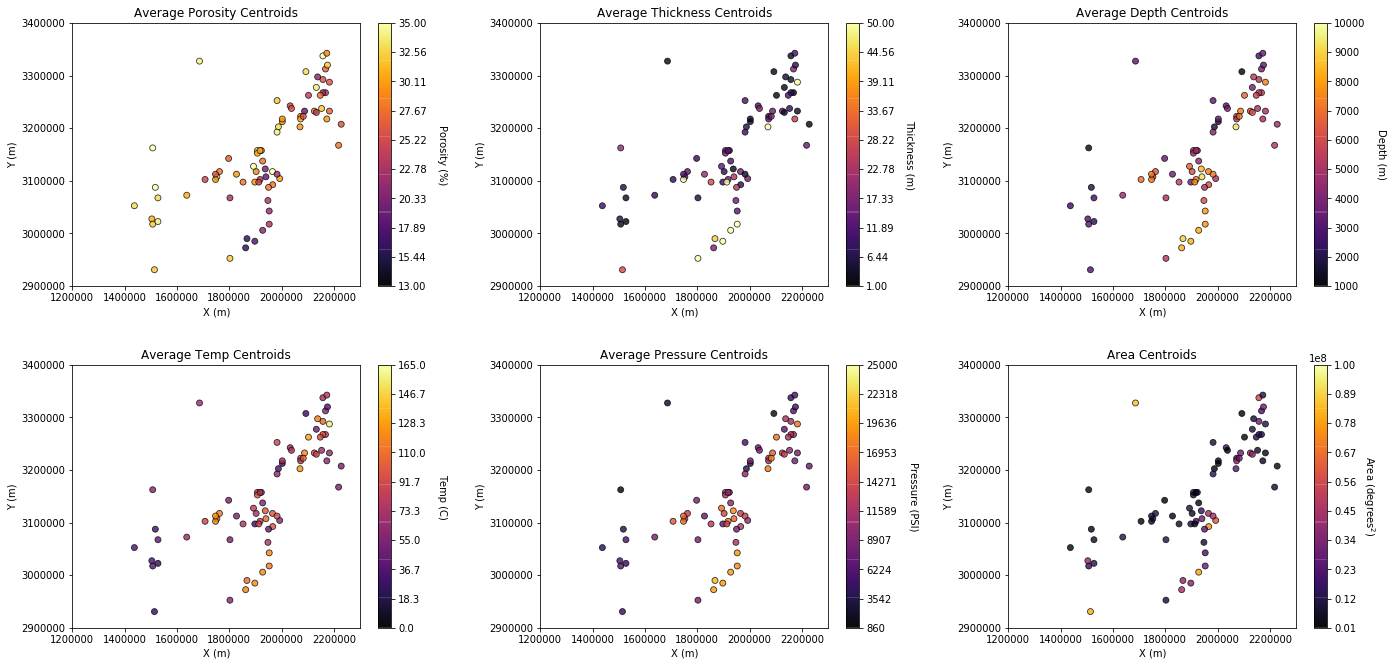

Polygons Actual Extents: 
X: 1383329.81 , 2228615.2

Y: 2921527.99 , 3463987.13


count          mean           std           min           25%  \
X       76.0  1.934019e+06  2.023070e+05  1.437500e+06  1.846250e+06   
Y       76.0  3.155570e+06  1.006490e+05  2.930833e+06  3.096250e+06   
Por     76.0  2.805263e+01  4.876870e+00  1.600000e+01  2.500000e+01   
Thick   76.0  2.203145e+01  4.250875e+01  1.110000e+00  6.750000e+00   
Depth   76.0  5.288829e+03  1.993540e+03  1.007000e+03  3.734500e+03   
Temp    76.0  7.910092e+01  2.997108e+01  2.333000e+01  5.778000e+01   
Press   76.0  1.108353e+04  4.969803e+03  8.600000e+02  7.615500e+03   
Area    76.0  2.094262e+07  1.993767e+07  7.700801e+05  6.929034e+06   

                50%           75%           max  
X      1.951250e+06  2.095000e+06  2.227500e+06  
Y      3.147500e+06  3.232500e+06  3.342500e+06  
Por    2.800000e+01  3.200000e+01  3.600000e+01  
Thick  1.193500e+01  1.725000e+01  3.280000e+02  
Depth  5.186000e+03  6.854750e+03  9.300000e+03  
Temp   7.694500e+01  1.001850e+02  1.572200e+02  
Press  1.087600e+04  1.396725e+04  2.089500e+04  
Area   1.427685e+07  3.050581e+07  8.555507e+07

In [917]:
# myproj = Proj("+proj=utm +zone=13T, +south +ellps=WGS84 +units=m +no_defs") # instantiate projection
# utm_ew, utm_ns = myproj(df["Longitude"].values, df["Latitude"].values, inverse= False) # project the test data
# df["Depth"] = df["Depth"] * 0.3048                        # depth converted to meters
# df["UTM_east"] = utm_ew                                   # add easting and northing to the DataFrame
# df["UTM_north"] = utm_ns
# ndata_orig = len(df)                                      # store the original number of data
# df.head()

axmin = 1.0e9; axmax = -1.0e9; aymin = 1.0e9; aymax = -1.0e9

ldata_cx = []; ldata_cy = []; ldata_cpor = []; ldata_cthick = []; ldata_cdepth = []; ldata_ctemp = []; 
ldata_cpress = []; ldata_carea = []; ldata_cage = []; ldata_cname = []; area = []; vol = []
for i, poly in enumerate(poly_list):
#     poly = polygon_extractor(spoly)
#     poly = polygon_projection(poly)                         # project polygons to UTMs
    pxmin, pxmax, pymin, pymax = polygon_minmax(poly)
    axmin = min(axmin,pxmin); axmax = max(axmax,pxmax); aymin = min(aymin,pymin); aymax = max(aymax,pymax)
    dx,dy = polygon_extract_centroid(poly,xx,yy)
    area.append(polygon_calculate_area(poly))
    vol.append(area[i]*por[i]/100*thick[i]*6.29/1000000)
    if dx > -990:
        ldata_cx.append(dx)
        ldata_cy.append(dy)
        ldata_cpor.append(por[i])
        ldata_cthick.append(thick[i])
        ldata_cdepth.append(depth[i])
        ldata_ctemp.append(temp[i])
        ldata_cpress.append(press[i])
        ldata_carea.append(area[i])
        ldata_cage.append(age[i])
        ldata_cname.append(name[i])
        
data_cx = np.array(ldata_cx); data_cy = np.array(ldata_cy); data_cpor = np.array(ldata_cpor)
data_cthick = np.array(ldata_cthick); data_cdepth = np.array(ldata_cdepth)
data_ctemp = np.array(ldata_ctemp); data_cpress = np.array(ldata_cpress); data_carea = np.array(ldata_carea)
data_cage = np.array(ldata_cage)
df_centroids = pd.DataFrame({'X':data_cx,'Y':data_cy,'Por':data_cpor,'Thick':data_cthick,'Depth':data_cdepth,'Temp':data_ctemp,
                             'Press':data_cpress,'Area':data_carea,'Age':data_cage,'Name':ldata_cname})
df_centroids.head()

plt.subplot(231)
GSLIB.locmap_st(df_centroids,"X","Y","Por",xmin,xmax,ymin,ymax,pormin,pormax,'Average Porosity Centroids','X (m)','Y (m)',"Porosity (%)",cmap)

plt.subplot(232)
GSLIB.locmap_st(df_centroids,"X","Y","Thick",xmin,xmax,ymin,ymax,thickmin,thickmax,'Average Thickness Centroids','X (m)','Y (m)',"Thickness (m)",cmap)

plt.subplot(233)
GSLIB.locmap_st(df_centroids,"X","Y","Depth",xmin,xmax,ymin,ymax,depthmin,depthmax,'Average Depth Centroids','X (m)','Y (m)',"Depth (m)",cmap)

plt.subplot(234)
GSLIB.locmap_st(df_centroids,"X","Y","Temp",xmin,xmax,ymin,ymax,tempmin,tempmax,'Average Temp Centroids','X (m)','Y (m)',"Temp (C)",cmap)

plt.subplot(235)
GSLIB.locmap_st(df_centroids,"X","Y","Press",xmin,xmax,ymin,ymax,pressmin,pressmax,'Average Pressure Centroids','X (m)','Y (m)',"Pressure (PSI)",cmap)

plt.subplot(236)
GSLIB.locmap_st(df_centroids,"X","Y","Area",xmin,xmax,ymin,ymax,areamin,areamax,'Area Centroids','X (m)','Y (m)','Area (degrees$^2$)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.3, hspace=0.3)
plt.show()

print('Polygons Actual Extents: \nX: ' + str(round(axmin,2)) + ' , ' + str(round(axmax,2)))
print('\nY: ' + str(round(aymin,2)) + ' , ' + str(round(aymax,2)))

df_centroids.describe().transpose()
#df_centroids.head()

#### Volumetric Calculation

We start with a simple volumetric response feature, note the area is not correct as the coordinates are not projected to meters

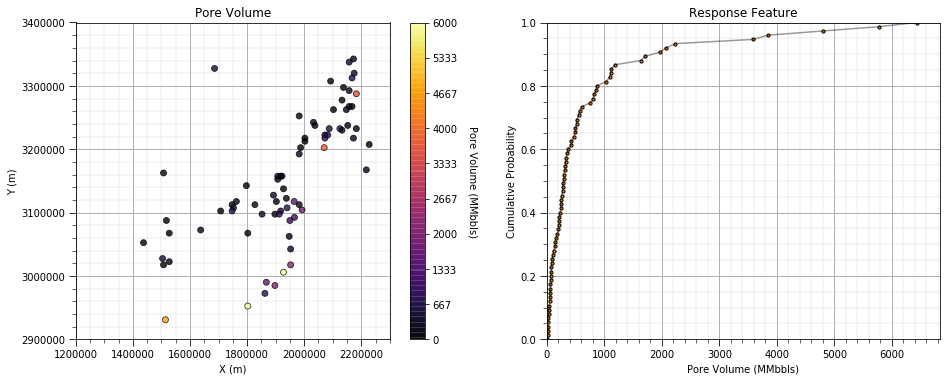

count          mean           std           min           25%  \
X             76.0  1.934019e+06  2.023070e+05  1.437500e+06  1.846250e+06   
Y             76.0  3.155570e+06  1.006490e+05  2.930833e+06  3.096250e+06   
Por           76.0  2.805263e+01  4.876870e+00  1.600000e+01  2.500000e+01   
Thick         76.0  2.203145e+01  4.250875e+01  1.110000e+00  6.750000e+00   
Depth         76.0  5.288829e+03  1.993540e+03  1.007000e+03  3.734500e+03   
Temp          76.0  7.910092e+01  2.997108e+01  2.333000e+01  5.778000e+01   
Press         76.0  1.108353e+04  4.969803e+03  8.600000e+02  7.615500e+03   
Area          76.0  2.094262e+07  1.993767e+07  7.700801e+05  6.929034e+06   
Pore_Volume   76.0  7.367722e+02  1.248212e+03  5.436206e+00  9.043039e+01   

                      50%           75%           max  
X            1.951250e+06  2.095000e+06  2.227500e+06  
Y            3.147500e+06  3.232500e+06  3.342500e+06  
Por          2.800000e+01  3.200000e+01  3.600000e+01  
Thick        1.193500e+01  1.725000e+01  3.280000e+02  
Depth        5.186000e+03  6.854750e+03  9.300000e+03  
Temp         7.694500e+01  1.001850e+02  1.572200e+02  
Press        1.087600e+04  1.396725e+04  2.089500e+04  
Area         1.427685e+07  3.050581e+07  8.555507e+07  
Pore_Volume  2.881114e+02  7.667951e+02  6.431983e+03

In [918]:
df_centroids['Pore_Volume'] = df_centroids['Area']*df_centroids['Thick']*df_centroids['Por']/100.0*6.29/1000000 # MMbbls
df_centroids['cPore_Volume'] = pd.cut(x=df_centroids['Pore_Volume'], bins=[0, 300, 1000, 7000],
                     labels=['Low', 'Mid', 'High'])

df_centroids.to_csv('df_centroids.csv')

df_centroids.head()
df_centroids.describe().transpose()

plt.subplot(121)
GSLIB.locmap_st(df_centroids,"X","Y","Pore_Volume",xmin,xmax,ymin,ymax,volmin,volmax,'Pore Volume','X (m)','Y (m)',"Pore Volume (MMbbls)",cmap)
add_grid()

plt.subplot(122)
plt.plot(np.sort(df_centroids['Pore_Volume'].values),np.linspace(0.0,1.0,len(df_centroids)),color='black',alpha=0.4)
plt.scatter(np.sort(df_centroids['Pore_Volume'].values),np.linspace(0.0,1.0,len(df_centroids)),s=10,color='darkorange',edgecolor='black')
plt.ylim([0,1]); plt.xlim(left=0); plt.xlabel('Pore Volume (MMbbls)'); plt.ylabel('Cumulative Probability'); plt.title('Response Feature')
add_grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.3); plt.show()

df_centroids.head()
df_centroids.describe().transpose()

#### Multivariate Analysis

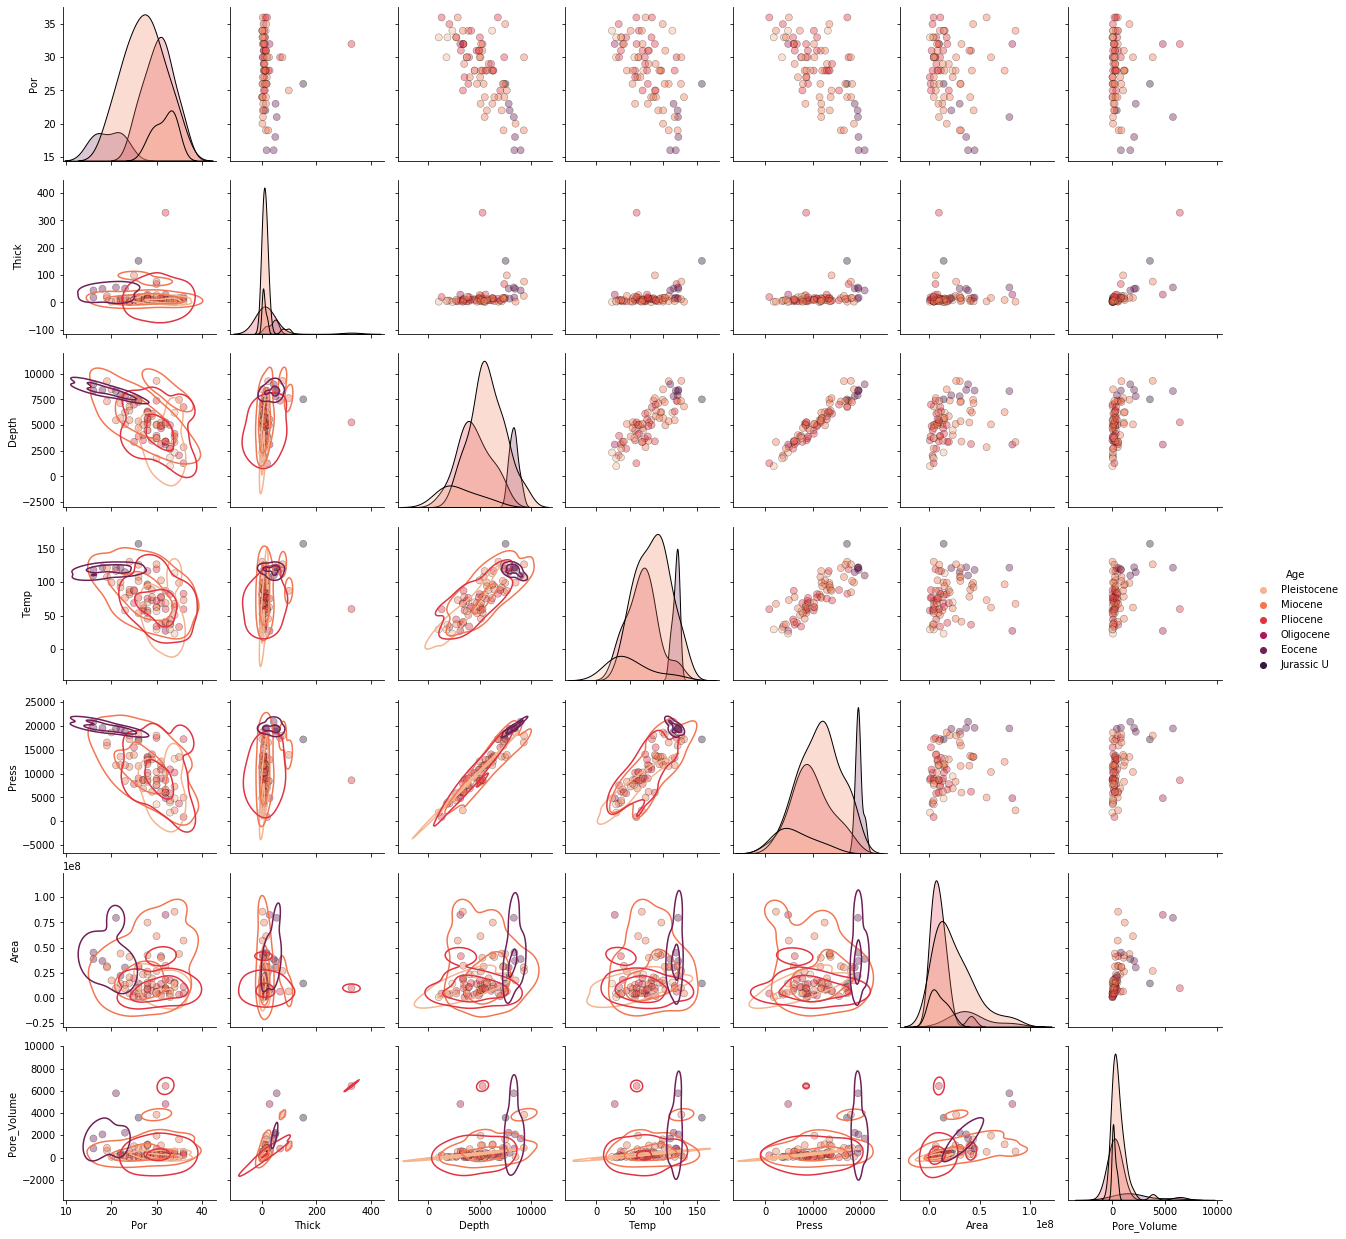

In [919]:
dpalette = sns.color_palette("rocket_r",n_colors = 6)
palette = sns.color_palette("rocket")
matrixplot = sns.pairplot(df_centroids,vars=['Por','Thick','Depth','Temp','Press','Area','Pore_Volume'],diag_kind = 'kde',hue='Age',palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.4))
matrixplot.map_lower(sns.kdeplot, levels=3, color="black")
#plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.2, hspace=0.3)
plt.show()

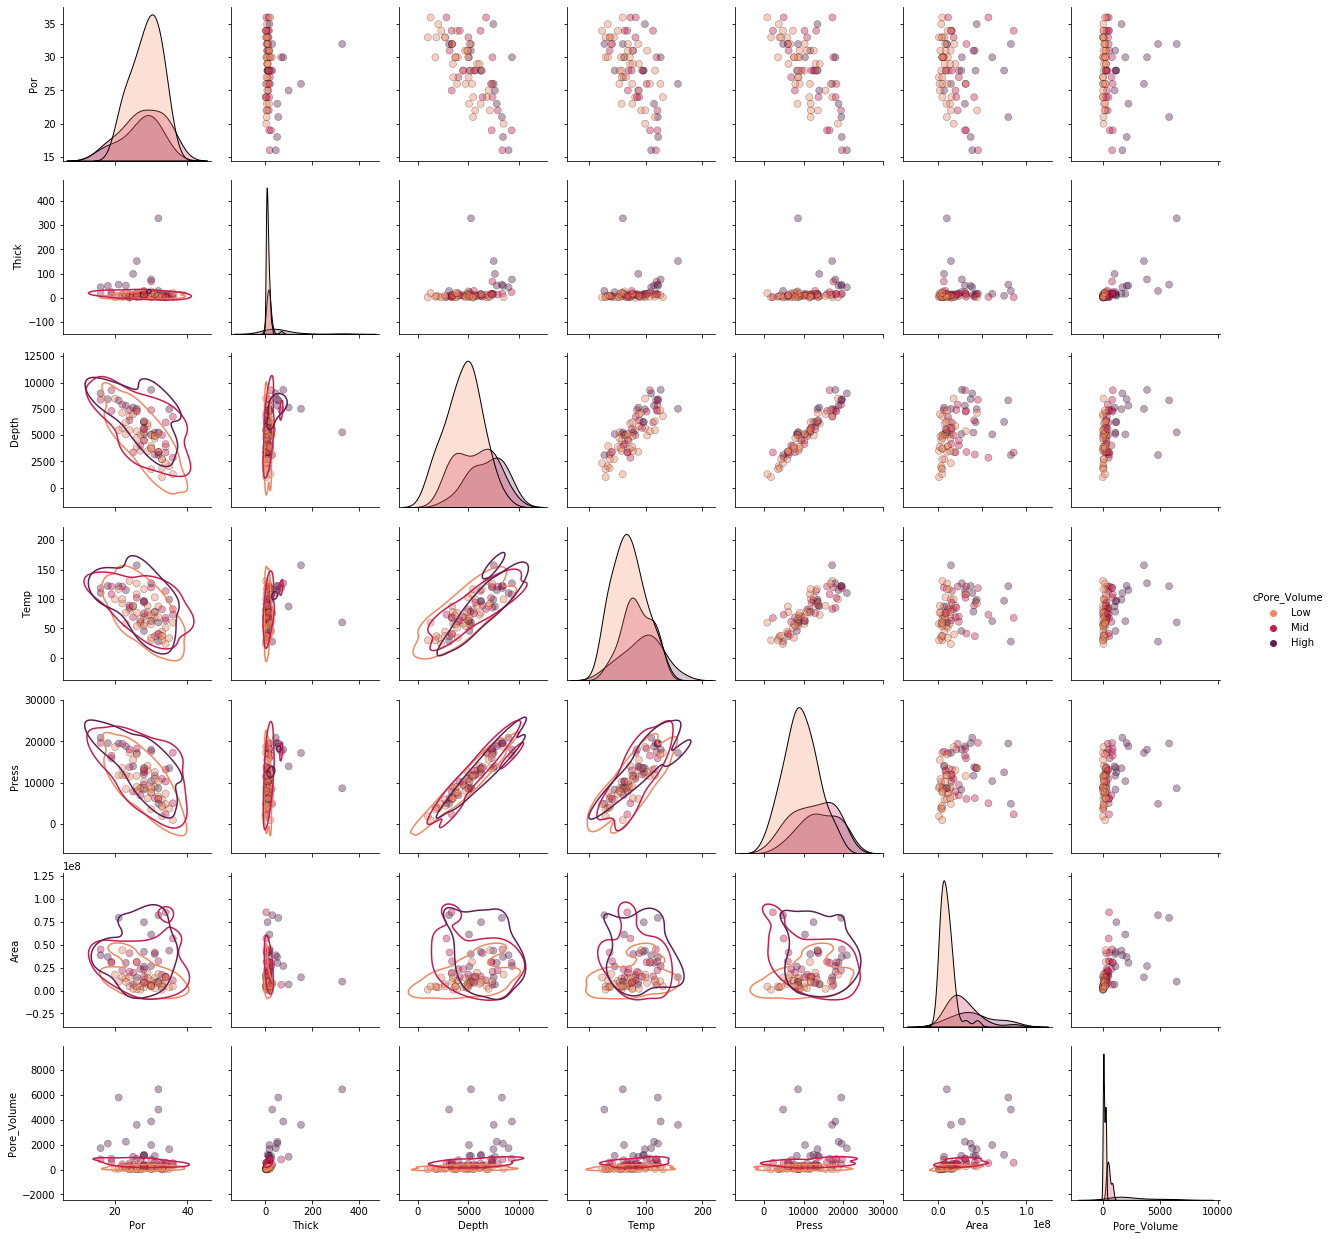

In [920]:
dpalette = sns.color_palette("rocket_r",n_colors = 3)
matrixplot = sns.pairplot(df_centroids,vars=['Por','Thick','Depth','Temp','Press','Area','Pore_Volume'],diag_kind = 'kde',hue='cPore_Volume',palette = dpalette,diag_kws={'edgecolor':'black'},plot_kws=dict(s=50, edgecolor="black", linewidth=0.5,alpha=0.4))
matrixplot.map_lower(sns.kdeplot, levels=2, color="black")
#plt.subplots_adjust(left=0.0, bottom=0.0, right=0.5, top=0.6, wspace=0.2, hspace=0.3)
plt.show()

#### Extract a Specific Reservoir Age

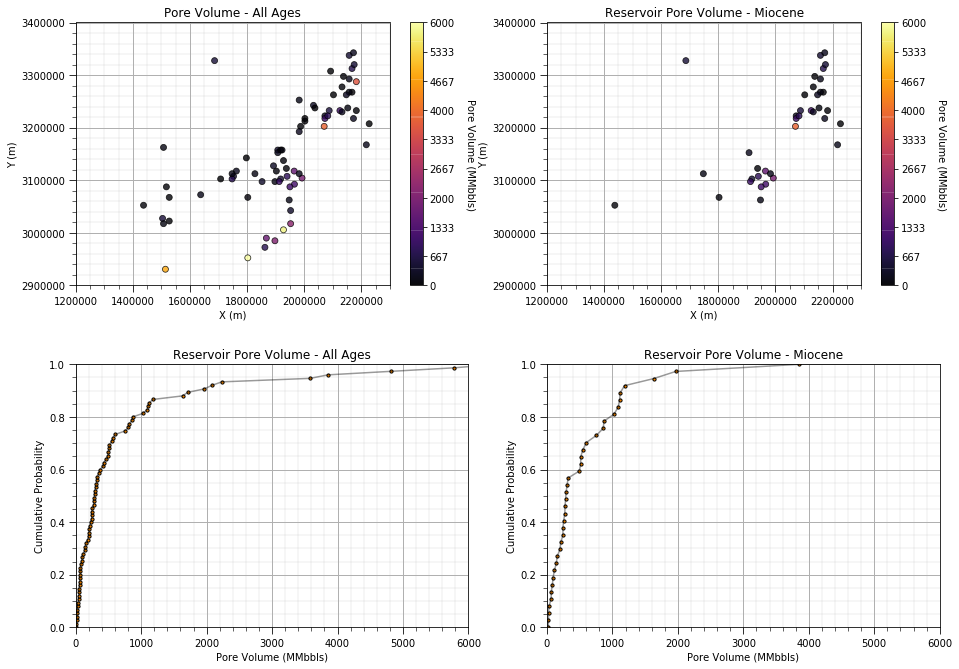

In [995]:
selected_age = 'Miocene'
df_centroids_age = df_centroids[df_centroids['Age']=='Miocene'].copy(deep=True)
#df_centroids_age = df_centroids[df_centroids['Age']=='Eocene'].copy(deep=True)

plt.subplot(221)
GSLIB.locmap_st(df_centroids,"X","Y","Pore_Volume",xmin,xmax,ymin,ymax,volmin,volmax,'Pore Volume - All Ages','X (m)','Y (m)',"Pore Volume (MMbbls)",cmap)
add_grid()

plt.subplot(223)
plt.plot(np.sort(df_centroids['Pore_Volume'].values),np.linspace(0.0,1.0,len(df_centroids)),color='black',alpha=0.4)
plt.scatter(np.sort(df_centroids['Pore_Volume'].values),np.linspace(0.0,1.0,len(df_centroids)),s=10,color='darkorange',edgecolor='black')
plt.ylim([0,1]); plt.xlim([0,volmax]); plt.xlabel('Pore Volume (MMbbls)'); plt.ylabel('Cumulative Probability'); plt.title('Reservoir Pore Volume - All Ages')
add_grid()

plt.subplot(222)
GSLIB.locmap_st(df_centroids_age,"X","Y","Pore_Volume",xmin,xmax,ymin,ymax,volmin,volmax,'Reservoir Pore Volume - ' + str(selected_age),'X (m)','Y (m)',"Pore Volume (MMbbls)",cmap)
add_grid()

plt.subplot(224)
plt.plot(np.sort(df_centroids_age['Pore_Volume'].values),np.linspace(0.0,1.0,len(df_centroids_age)),color='black',alpha=0.4)
plt.scatter(np.sort(df_centroids_age['Pore_Volume'].values),np.linspace(0.0,1.0,len(df_centroids_age)),s=10,color='darkorange',edgecolor='black')
plt.ylim([0,1]); plt.xlim([0,volmax]); plt.xlabel('Pore Volume (MMbbls)'); plt.ylabel('Cumulative Probability'); plt.title('Reservoir Pore Volume - ' + str(selected_age))
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.3); plt.show()


In [1012]:
afeatures

['Por', 'Thick', 'Depth', 'Temp', 'Press', 'Area', 'Por_Volume']

#### Declustering

There are 38 data with:
   mean of      27.210526315789473 
   min and max  19.0 and 36.0
   standard dev 4.407875098149495 
Selected Cell Size: 304062.0
Naive mean = 27.210526315789473, Declustered mean = 29.05338991207619.


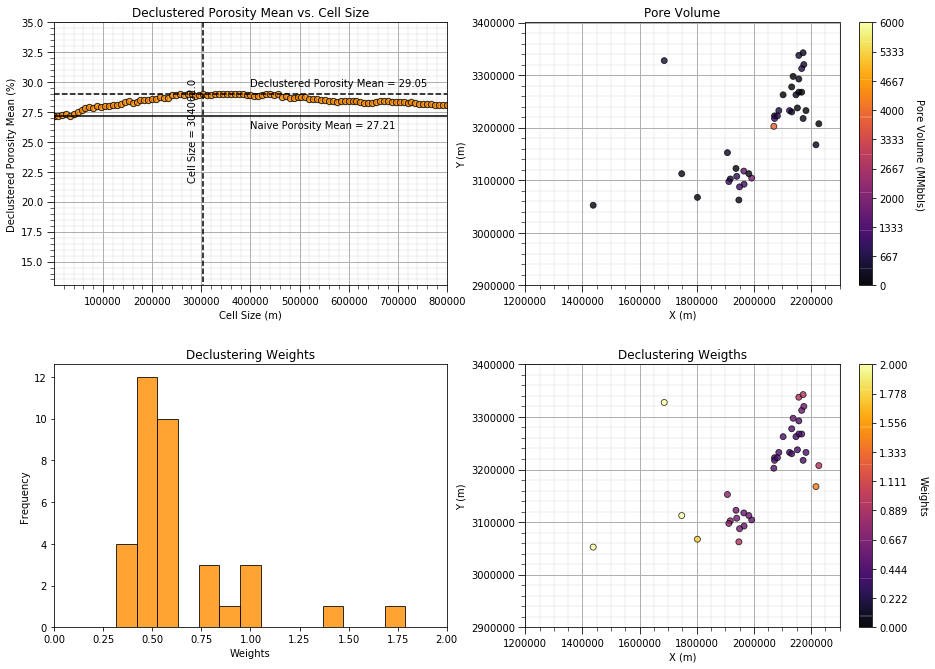

In [1070]:
cmin = 100.0; cmax = 800000; ncell = 100; iminmax = 0

wts, cell_sizes, dmeans = geostats.declus(df_centroids,'X','Y','Por',iminmax = iminmax, noff= 10, ncell=ncell,cmin=cmin,cmax=cmax)
df_centroids['Wts'] = wts                            # add weights to the sample data DataFrame
df_centroids.head()                                  # preview to check the sample data DataFrame

if iminmax == 1:
    icell_size = np.argmin(dmeans)
else:
    icell_size = np.argmax(dmeans)
cell_size = cell_sizes[icell_size]

print('Selected Cell Size: ' + str(cell_size))

por_centroids_mean = np.average(df_centroids['Por'].values); por_centroids_var = np.var(df_centroids['Por'].values)
por_centroids_dmean,por_centroids_dstd = weighted_avg_and_std(df_centroids['Por'].values,df_centroids['Wts'].values)
por_centroids_dvar = por_centroids_dstd*por_centroids_dstd

thick_centroids_mean = np.average(df_centroids['Thick'].values); thick_centroids_var = np.var(df_centroids['Thick'].values)
thick_centroids_dmean,thick_centroids_dstd = weighted_avg_and_std(df_centroids['Por'].values,df_centroids['Wts'].values)
thick_centroids_dvar = thick_centroids_dstd*thick_centroids_dstd

print('Naive mean = ' + str(por_centroids_mean) + ', Declustered mean = ' + str(por_centroids_dmean) + '.')

plt.subplot(221)
plt.scatter(cell_sizes,dmeans, s=40, alpha = 0.8, edgecolors = "black", facecolors = 'darkorange')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (%)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,cmax],[por_centroids_mean,por_centroids_mean],color = 'black')
plt.plot([cell_size,cell_size],[0,999],color = 'black',linestyle='dashed')
plt.plot([0,cmax],[por_centroids_dmean,por_centroids_dmean],color = 'black',linestyle='dashed')
plt.text(cmax*0.5,por_centroids_mean*0.96, r'Naive Porosity Mean = ' + str(np.round(por_centroids_mean,2)))
plt.text(cmax*0.5,por_centroids_dmean*1.02, r'Declustered Porosity Mean = ' + str(np.round(por_centroids_dmean,2)))
# plt.text(230., 0.154, r'Minimizing')
plt.text(cell_size*.90, por_centroids_mean*0.8, r'Cell Size = ' + str(np.round(cell_size,2)),rotation=90)
plt.ylim(pormin,pormax); plt.xlim(cmin,cmax); add_grid()
#plt.xscale('log');

plt.subplot(222)
GSLIB.locmap_st(df_centroids,"X","Y","Pore_Volume",xmin,xmax,ymin,ymax,volmin,volmax,'Pore Volume','X (m)','Y (m)',"Pore Volume (MMbbls)",cmap)
add_grid()

plt.subplot(223)
plt.hist(df_centroids['Wts'],bins=np.linspace(0.0,2.0,20),color='darkorange',edgecolor='black',alpha=0.8)
plt.xlim([0.0,2.0]); plt.xlabel('Weights'); plt.ylabel('Frequency'); plt.title('Declustering Weights')

plt.subplot(224)
GSLIB.locmap_st(df_centroids,"X","Y","Wts",xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weigths','X (m)','Y (m)',"Weights",cmap)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.3)
plt.show()

#### Declustered Distributions

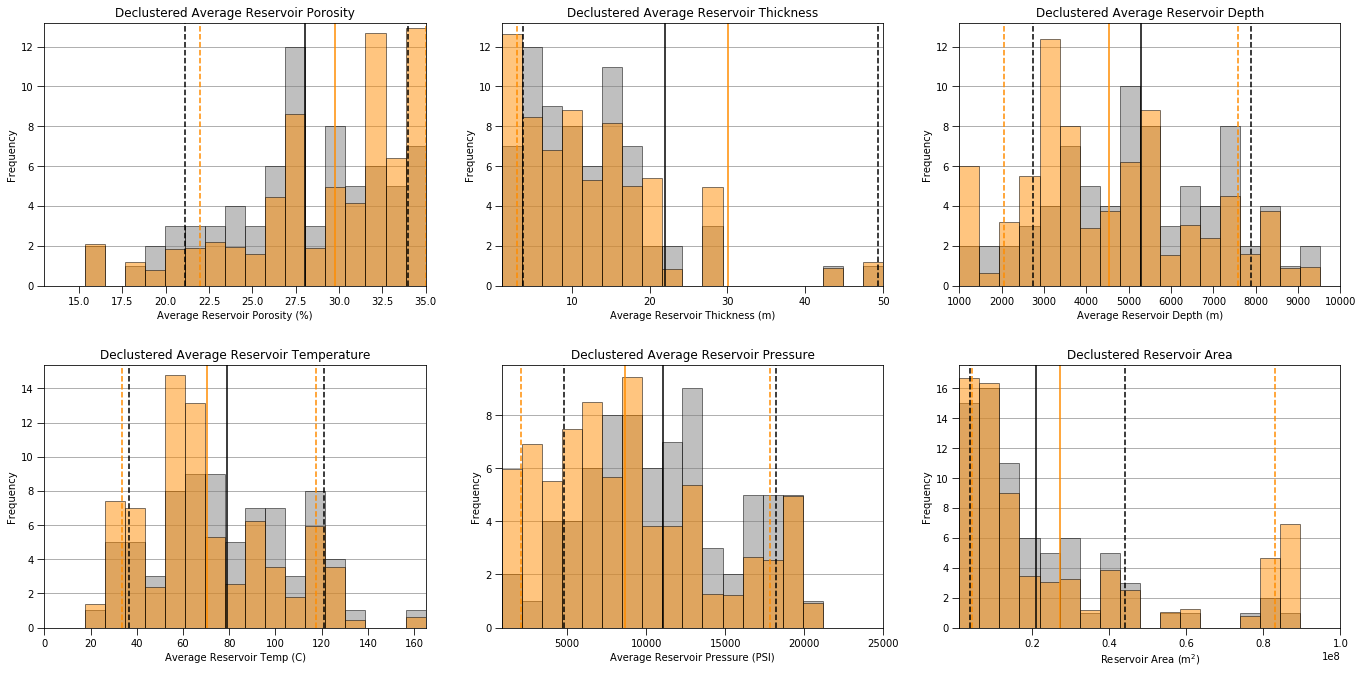

In [973]:
nbins = 20

plt.subplot(231)
hist = plt.hist(x=df_centroids['Por'],weights=None,bins=np.linspace(pormin,pormax,nbins),alpha = 0.5,edgecolor='black',color='grey')
hist = plt.hist(x=df_centroids['Por'],weights=df_centroids['Wts'],bins=np.linspace(pormin,pormax,nbins),alpha = 0.5,edgecolor='black',color='darkorange'); plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4); plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grid
plt.xlabel('Average Reservoir Porosity (%)'); plt.ylabel('Frequency'); plt.title('Declustered Average Reservoir Porosity') # axes labels
plt.xlim(pormin,pormax); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           
histogram_bounds(df_centroids['Por'],np.ones(len(df_centroids)),'black')
histogram_bounds(df_centroids['Por'],df_centroids['Wts'],'darkorange')

plt.subplot(232)
hist = plt.hist(x=df_centroids['Thick'],weights=None,bins=np.linspace(thickmin,thickmax,nbins),alpha = 0.5,edgecolor='black',color='grey')
hist = plt.hist(x=df_centroids['Thick'],weights=df_centroids['Wts'],bins=np.linspace(thickmin,thickmax,nbins),alpha = 0.5,edgecolor='black',color='darkorange'); plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4); plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grid
plt.xlabel('Average Reservoir Thickness (m)'); plt.ylabel('Frequency'); plt.title('Declustered Average Reservoir Thickness') # axes labels
plt.xlim(thickmin,thickmax); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           
histogram_bounds(df_centroids['Thick'],np.ones(len(df_centroids)),'black')
histogram_bounds(df_centroids['Thick'],df_centroids['Wts'],'darkorange')

plt.subplot(233)
hist = plt.hist(x=df_centroids['Depth'],weights=None,bins=np.linspace(depthmin,depthmax,nbins),alpha = 0.5,edgecolor='black',color='grey')
hist = plt.hist(x=df_centroids['Depth'],weights=df_centroids['Wts'],bins=np.linspace(depthmin,depthmax,nbins),alpha = 0.5,edgecolor='black',color='darkorange'); plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4); plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grid
plt.xlabel('Average Reservoir Depth (m)'); plt.ylabel('Frequency'); plt.title('Declustered Average Reservoir Depth') # axes labels
plt.xlim(depthmin,depthmax); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           
histogram_bounds(df_centroids['Depth'],np.ones(len(df_centroids)),'black')
histogram_bounds(df_centroids['Depth'],df_centroids['Wts'],'darkorange')

plt.subplot(234)
hist = plt.hist(x=df_centroids['Temp'],weights=None,bins=np.linspace(tempmin,tempmax,nbins),alpha = 0.5,edgecolor='black',color='grey')
hist = plt.hist(x=df_centroids['Temp'],weights=df_centroids['Wts'],bins=np.linspace(tempmin,tempmax,nbins),alpha = 0.5,edgecolor='black',color='darkorange'); plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4); plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grid
plt.xlabel('Average Reservoir Temp (C)'); plt.ylabel('Frequency'); plt.title('Declustered Average Reservoir Temperature') # axes labels
plt.xlim(tempmin,tempmax); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           
histogram_bounds(df_centroids['Temp'],np.ones(len(df_centroids)),'black')
histogram_bounds(df_centroids['Temp'],df_centroids['Wts'],'darkorange')

plt.subplot(235)
hist = plt.hist(x=df_centroids['Press'],weights=None,bins=np.linspace(pressmin,pressmax,nbins),alpha = 0.5,edgecolor='black',color='grey') 
hist = plt.hist(x=df_centroids['Press'],weights=df_centroids['Wts'],bins=np.linspace(pressmin,pressmax,nbins),alpha = 0.5,edgecolor='black',color='darkorange'); plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4); plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grid
plt.xlabel('Average Reservoir Pressure (PSI)'); plt.ylabel('Frequency'); plt.title('Declustered Average Reservoir Pressure') # axes labels
plt.xlim(pressmin,pressmax); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           
histogram_bounds(df_centroids['Press'],np.ones(len(df_centroids)),'black')
histogram_bounds(df_centroids['Press'],df_centroids['Wts'],'darkorange')

plt.subplot(236)
hist = plt.hist(x=df_centroids['Area'],weights=None,bins=np.linspace(areamin,areamax,nbins),alpha = 0.5,edgecolor='black',color='grey')
hist = plt.hist(x=df_centroids['Area'],weights=df_centroids['Wts'],bins=np.linspace(areamin,areamax,nbins),alpha = 0.5,edgecolor='black',color='darkorange'); plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4); plt.gca().yaxis.grid(True, which='major',linewidth = 1.0); plt.gca().yaxis.grid(True, which='minor',linewidth = 0.2) # add y grid
plt.xlabel('Reservoir Area (m$^2$)'); plt.ylabel('Frequency'); plt.title('Declustered Reservoir Area') # axes labels
plt.xlim(areamin,areamax); plt.ylim([0,int(max(hist[0]))*1.1])                      # constrain the axes' extents                           
histogram_bounds(df_centroids['Area'],np.ones(len(df_centroids)),'black')
histogram_bounds(df_centroids['Area'],df_centroids['Wts'],'darkorange')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.2, hspace=0.3)
plt.show()

#### Conditional Probability

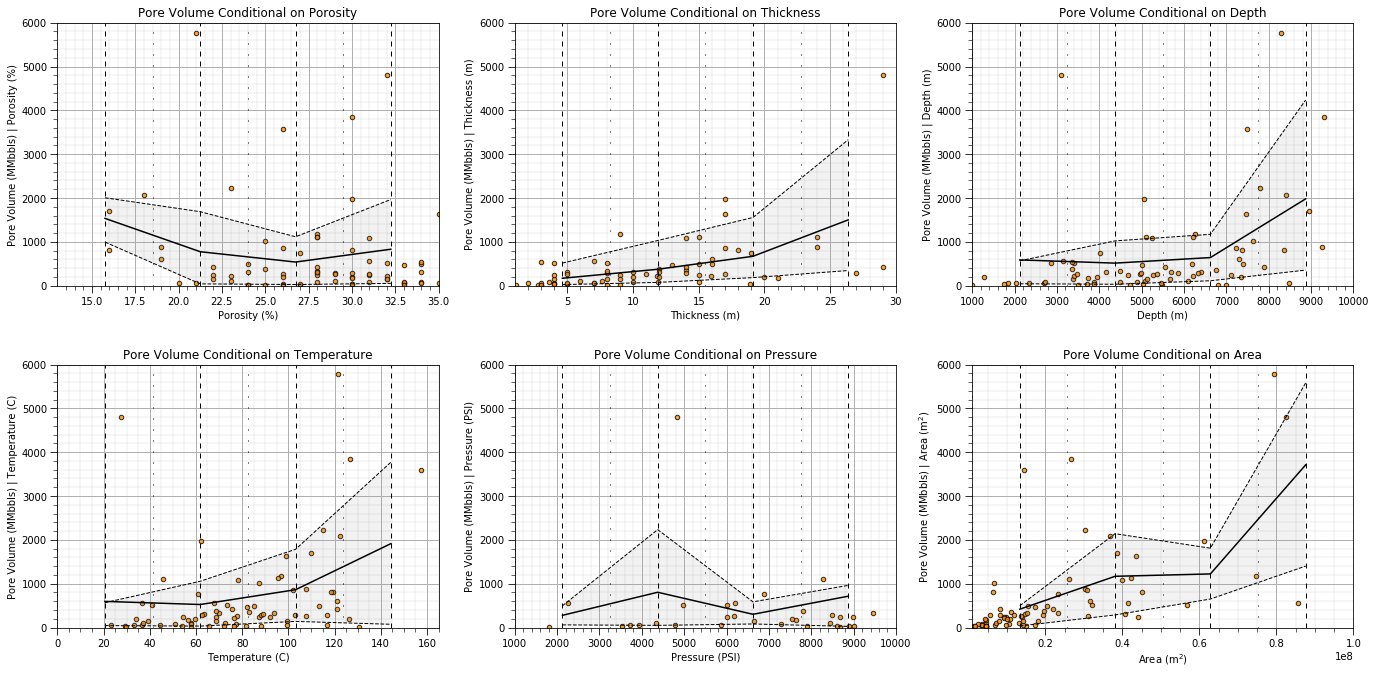

In [974]:
plt.subplot(231)
cond_prob_plot(df_centroids['Por'],pormin,pormax,'Porosity','%',4,df_centroids['Pore_Volume'],volmin,volmax,'Pore Volume','MMbbls')
  
plt.subplot(232)
cond_prob_plot(df_centroids['Thick'],thickmin,30,'Thickness','m',4,df_centroids['Pore_Volume'],volmin,volmax,'Pore Volume','MMbbls')
  
plt.subplot(233)
cond_prob_plot(df_centroids['Depth'],depthmin,depthmax,'Depth','m',4,df_centroids['Pore_Volume'],volmin,volmax,'Pore Volume','MMbbls')

plt.subplot(234)
cond_prob_plot(df_centroids['Temp'],tempmin,tempmax,'Temperature','C',4,df_centroids['Pore_Volume'],volmin,volmax,'Pore Volume','MMbbls')

plt.subplot(235)
cond_prob_plot(df_centroids['Press'],depthmin,depthmax,'Pressure','PSI',4,df_centroids['Pore_Volume'],volmin,volmax,'Pore Volume','MMbbls')

plt.subplot(236)
cond_prob_plot(df_centroids['Area'],areamin,areamax,'Area','m$^2$',4,df_centroids['Pore_Volume'],volmin,volmax,'Pore Volume','MMbbls')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3., top=2.1, wspace=0.2, hspace=0.3)
plt.show()

#### Enhanced Correlation Analysis 

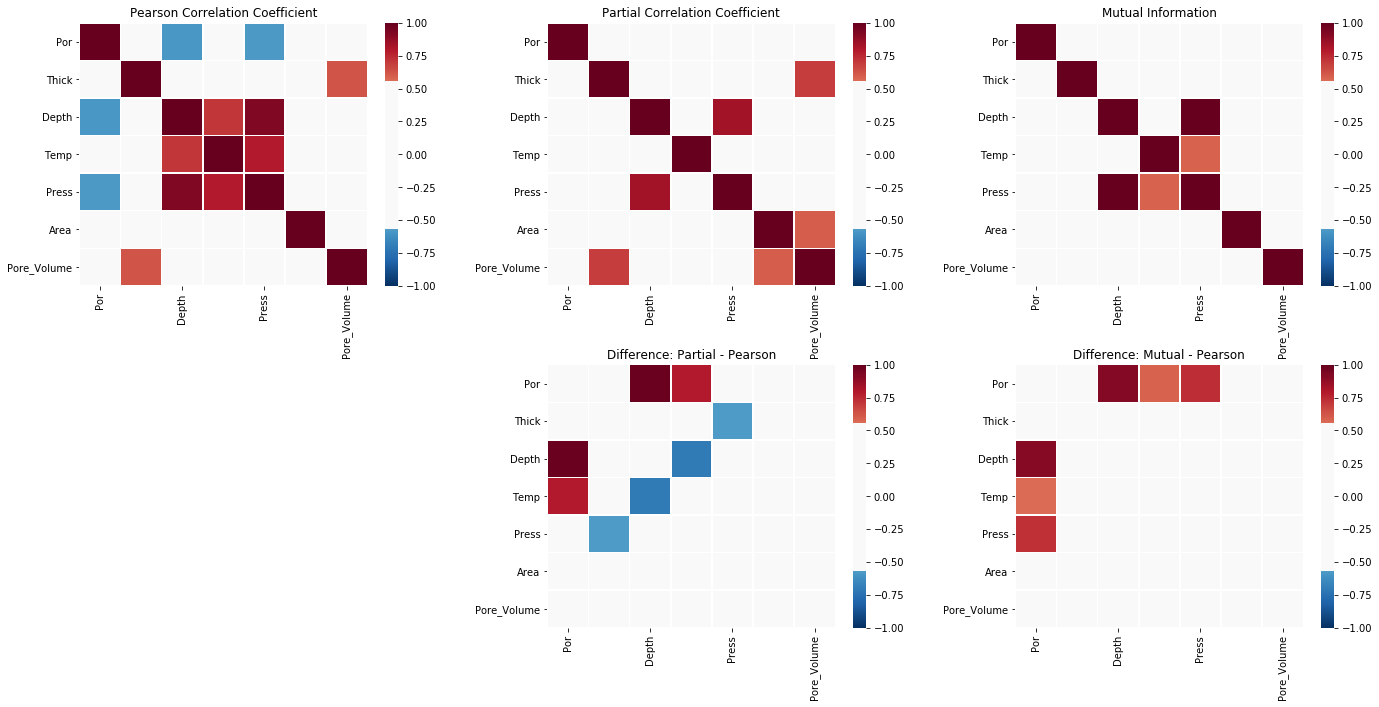

In [1018]:
plt.subplot(231)                          # plot a color coded correlation matrix
df_corr = df_centroids_age[afeatures].corr()
sns.heatmap(df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.title('Pearson Correlation Coefficient')

plt.subplot(232)                          # plot a color coded correlation matrix
partial_correlation = partial_corr(df_centroids_age[afeatures]) # calculate the partial correlation coefficients
df_partial = pd.DataFrame(partial_correlation,columns=afeatures,index=afeatures)
sns.heatmap(df_partial,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)
plt.title('Partial Correlation Coefficient')

plt.subplot(233)
df_mutual = pd.DataFrame(mutual_matrix(df_centroids_age[afeatures],afeatures),columns=afeatures,index=afeatures)
sns.heatmap(df_mutual,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)  
plt.title('Mutual Information')

plt.subplot(235)
sns.heatmap(df_partial-df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif)  
plt.title('Difference: Partial - Pearson')

plt.subplot(236)
plot = sns.heatmap(df_mutual-df_corr,vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f',cmap = signif) 

plt.title('Difference: Mutual - Pearson')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.3, hspace=0.3)
plt.show()

#df_centroids_age.head(n=200)

#### Normalize Predictor Features

In [1020]:
from sklearn.preprocessing import MinMaxScaler

norm_df_centroids_age = df_centroids_age.copy(deep=True)
scaler = MinMaxScaler() 
norm_df_centroids_age[features] = scaler.fit_transform(df_centroids_age[afeatures]) 
norm_df_centroids_age

X             Y       Por     Thick     Depth      Temp  \
1   2.157500e+06  3.337500e+06  1.000000  0.029523  0.020352  0.386865   
2   2.132500e+06  3.277500e+06  0.882353  0.025641  0.177704  0.148811   
5   1.802500e+06  3.067500e+06  0.235294  0.049954  0.357989  0.220270   
10  2.167500e+06  3.312500e+06  0.470588  0.182756  0.198360  0.255946   
12  1.992500e+06  3.104167e+06  0.647059  0.162325  0.356470  0.267838   
13  2.167500e+06  3.267500e+06  0.294118  0.000000  0.419502  0.476216   
14  2.175000e+06  3.320000e+06  0.764706  0.070385  0.103129  0.041676   
18  1.965000e+06  3.117500e+06  0.941176  0.162325  0.721294  0.660703   
20  2.072500e+06  3.222500e+06  0.588235  0.070385  0.476914  0.547568   
23  2.072500e+06  3.217500e+06  0.705882  0.131678  0.384265  0.440433   
26  1.965833e+06  3.092500e+06  0.529412  0.080601  0.538275  0.638847   
28  2.125000e+06  3.232500e+06  0.529412  0.141894  0.532047  0.625027   
30  2.102500e+06  3.262500e+06  0.294118  0.017060  0.621810  1.000000   
31  2.132500e+06  3.230000e+06  0.294118  0.039738  0.560601  0.553568   
32  1.982500e+06  3.112500e+06  0.176471  0.029523  0.668894  0.589244   
35  2.172500e+06  3.342500e+06  0.588235  0.101032  0.115735  0.434540   
37  1.907500e+06  3.152500e+06  0.705882  0.162325  0.342041  0.702378   
38  1.437500e+06  3.052500e+06  0.823529  0.090816  0.000000  0.000000   
41  1.950000e+06  3.087500e+06  0.529412  0.233834  0.362849  0.089351   
42  2.087500e+06  3.232500e+06  0.000000  0.152110  0.696233  0.898757   
44  1.917500e+06  3.102500e+06  0.294118  0.152110  0.709143  0.511892   
47  2.182500e+06  3.232500e+06  0.470588  0.029523  0.351914  0.303621   
48  1.940000e+06  3.107500e+06  0.000000  0.233834  0.994988  0.755946   
50  2.157500e+06  3.267500e+06  0.176471  0.070385  0.450486  0.668631   
51  2.217500e+06  3.167500e+06  0.529412  0.141894  0.388821  0.184487   
53  1.937500e+06  3.122500e+06  0.058824  0.019307  0.874392  0.666595   
55  2.172500e+06  3.217500e+06  0.647059  0.264481  0.344623  0.273838   
56  1.912500e+06  3.097500e+06  0.352941  1.000000  0.744836  0.535676   
57  1.947500e+06  3.062500e+06  0.235294  0.151701  0.532047  0.422648   
60  2.147500e+06  3.262500e+06  0.529412  0.111247  0.451245  0.607135   
63  2.070000e+06  3.202500e+06  0.647059  0.767086  1.000000  0.958324   
67  2.157500e+06  3.292500e+06  0.411765  0.039738  0.402795  0.755946   
68  2.227500e+06  3.207500e+06  0.411765  0.019307  0.304070  0.178594   
69  1.747500e+06  3.112500e+06  0.411765  0.111247  0.703372  0.952325   
70  2.152500e+06  3.237500e+06  0.764706  0.080601  0.366039  0.339297   
71  2.082500e+06  3.222500e+06  0.411765  0.162325  0.686209  0.692415   
72  2.137500e+06  3.297500e+06  0.117647  0.039738  0.417375  0.851189   
74  1.686250e+06  3.327500e+06  0.882353  0.019307  0.096294  0.327405   

       Press      Area      Age                     Name  Pore_Volume  \
1   0.165191  0.646790  Miocene               Ram-Powell     0.129472   
2   0.306382  0.076476  Miocene                   Kepler     0.016521   
5   0.377893  0.106844  Miocene                 Red Hawk     0.024713   
10  0.281588  0.232947  Miocene            Horn Mountain     0.191693   
12  0.493435  0.700715  Miocene                 Atlantis     0.507994   
13  0.558473  0.128087  Miocene                  Fourier     0.001443   
14  0.228519  0.339981  Miocene                     King     0.129588   
18  0.685191  0.482792  Miocene                       K2     0.420960   
20  0.654412  0.185278  Miocene                 Princess     0.069205   
23  0.574168  0.436732  Miocene                     Ursa     0.279084   
26  0.623878  0.866802  Miocene                  Mad Dog     0.304146   
28  0.688611  0.466996  Miocene      Thunder Horse North     0.286833   
30  0.913221  0.001688  Miocene                   Hawkes     0.000000   
31  0.700763  0.447257  Miocene            Thunder Horse     0.075188   
32  0.689954  0.488320  Miocene  

#### Multidimensional Scaling

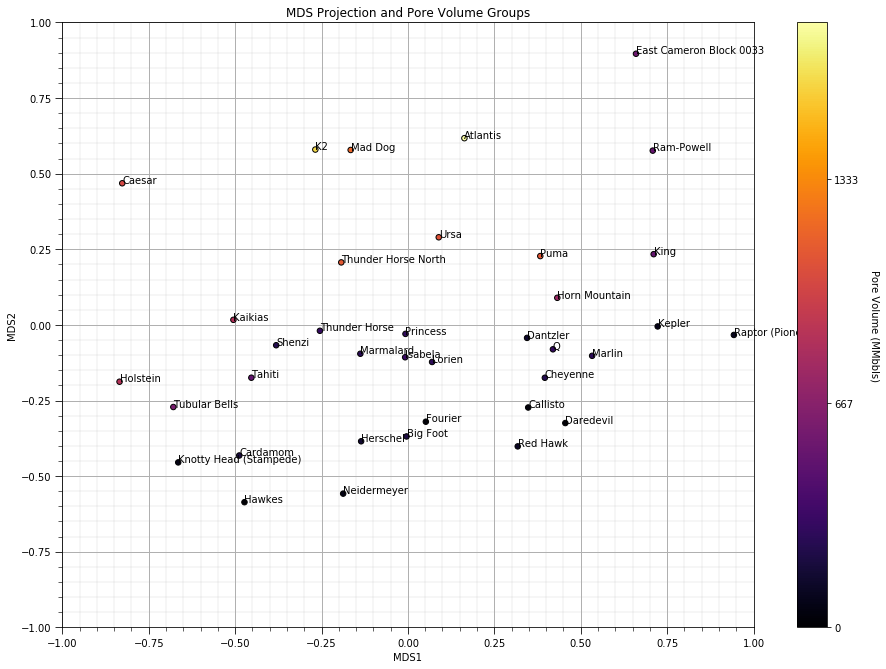

In [1021]:
np.random.seed(1867)                               # set the random number seed, so we all get the same answer
n_components = 2                                   # p, reduced dimensionality space
embedding = MDS(n_components=2,n_init = 20,max_iter = 1000,random_state = 73073) # instantiate and set the hyperparameter
MDS_transformed = embedding.fit_transform(norm_df_centroids_age[features])
df_centroids_age['MDS1'] = MDS_transformed[:,0]; df_centroids_age['MDS2'] = MDS_transformed[:,1]
df_centroids_age.head()
scat = plt.scatter(df_centroids_age['MDS1'],df_centroids_age['MDS2'],c = df_centroids_age['Pore_Volume'],s=30,cmap = plt.cm.inferno,vmin=volmin,vmax=volmax*.3,edgecolor="black")
plt.title('MDS Projection and Pore Volume Groups')
plt.xlabel('MDS1'); plt.ylabel('MDS2')
plt.xlim([-1,1]); plt.ylim([-1,1])
cbar = plt.colorbar(scat, orientation="vertical", ticks=np.linspace(volmin, volmax, 10))
cbar.set_label('Pore Volume (MMbbls)', rotation=270, labelpad=20)
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
  
# plt.gca().add_patch(Ellipse((-600, -0),width=9000,height=2000,angle=100,facecolor='none',edgecolor='black',label='Low')) 
# plt.gca().add_patch(Ellipse((-500, 4300),width=1000,height=1000,angle=135,facecolor='none',edgecolor='orange',label='High')) 
# plt.gca().add_patch(Ellipse((2000, -4000),width=1000,height=1000,angle=135,facecolor='none',edgecolor='orange')) 
# plt.gca().add_patch(Ellipse((1300, -500),width=6000,height=1000,angle=115,facecolor='none',edgecolor='red',label='Mid')) 
# plt.legend(loc='upper right')    
 
for i, field_name in enumerate(df_centroids_age['Name']):
     plt.annotate(field_name,(df_centroids_age['MDS1'].values[i],df_centroids_age['MDS2'].values[i]))
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.3, hspace=0.3)
plt.show()


#### Trend Modeling

For now we include all ages for demonstration.

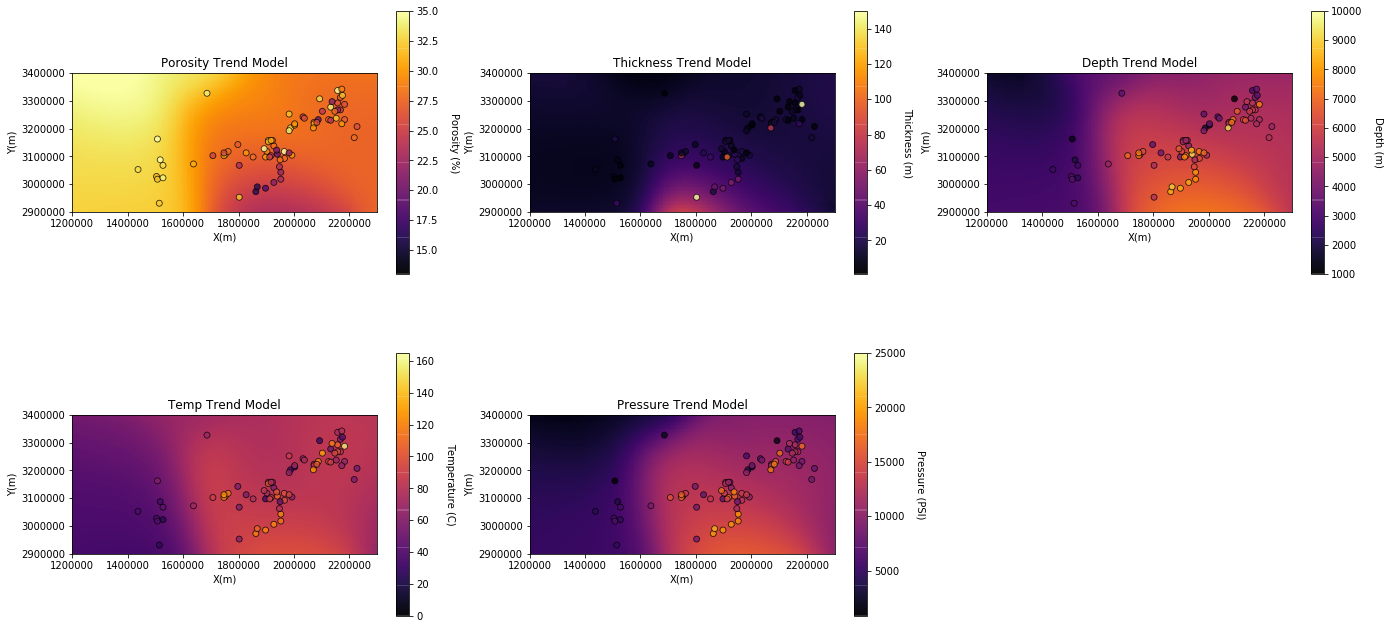

In [1022]:
ktype = 1                                  # kriging type, 0 - simple, 1 - ordinary
radius = 100                               # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 40                      # minimum and maximum data for an estimate
tmin = -1.0e21; tmax = 1.0e21              # minimum property value - no trimming limits

trend_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=3.0,hmin1=3.0) # porosity variogram

calculate = False; kriging = False;

if calculate == True:
    if kriging:
        trend_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=3.0,hmin1=3.0) # porosity variogram
            
        por_trend, _ = geostats.kb2d(df_centroids,'X','Y','Por',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,radius,ktype,-9999,trend_vario)
    
        thick_trend, _ = geostats.kb2d(df_centroids,'X','Y','Thick',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,radius,ktype,-9999,trend_vario)
    
        depth_trend, _ = geostats.kb2d(df_centroids,'X','Y','Depth',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,radius,ktype,-9999,trend_vario)
    
        temp_trend, _ = geostats.kb2d(df_centroids,'X','Y','Temp',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,radius,ktype,-9999,trend_vario)
    
        press_trend, _ = geostats.kb2d(df_centroids,'X','Y','Press',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,radius,ktype,-9999,trend_vario)
        
    else:
        
        r = 21                             # make the 2D Gaussian kernel
        s = 141
        
        gkern1d = signal.gaussian(s,r).reshape(s, 1)
        gkern2d = np.outer(gkern1d, gkern1d)
        print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))  
        
        por_grid = GSLIB.DataFrame2ndarray(df_centroids,'X','Y','Por',xmin, xmax, ymin, ymax, xsiz) # assumes x and y size are the same
        por_trend = convolve(por_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)
        
        thick_grid = GSLIB.DataFrame2ndarray(df_centroids,'X','Y','Thick',xmin, xmax, ymin, ymax, xsiz) # assumes x and y size are the same
        thick_trend = convolve(thick_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

        depth_grid = GSLIB.DataFrame2ndarray(df_centroids,'X','Y','Depth',xmin, xmax, ymin, ymax, xsiz) # assumes x and y size are the same
        depth_trend = convolve(depth_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)
        
        temp_grid = GSLIB.DataFrame2ndarray(df_centroids,'X','Y','Temp',xmin, xmax, ymin, ymax, xsiz) # assumes x and y size are the same
        temp_trend = convolve(temp_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)
        
        press_grid = GSLIB.DataFrame2ndarray(df_centroids,'X','Y','Press',xmin, xmax, ymin, ymax, xsiz) # assumes x and y size are the same
        press_trend = convolve(press_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)
                        
    
    np.savetxt("por_trend.csv", por_trend, delimiter=","); np.savetxt("thick_trend.csv", thick_trend, delimiter=",");
    np.savetxt("depth_trend.csv", depth_trend, delimiter=","); np.savetxt("temp_trend.csv", temp_trend, delimiter=",");
    np.savetxt("press_trend.csv", press_trend, delimiter=",")
    
else:
    por_trend = np.loadtxt("por_trend.csv", delimiter=","); thick_trend = np.loadtxt("thick_trend.csv", delimiter=",")  
    depth_trend = np.loadtxt("depth_trend.csv", delimiter=","); temp_trend = np.loadtxt("temp_trend.csv", delimiter=",")  
    press_trend = np.loadtxt("press_trend.csv", delimiter=",")    
    

plt.subplot(231)
GSLIB.locpix_st(por_trend,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df_centroids,'X','Y','Por','Porosity Trend Model','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(232)
GSLIB.locpix_st(thick_trend,xmin,xmax,ymin,ymax,xsiz,thickmin,150,df_centroids,'X','Y','Thick','Thickness Trend Model','X(m)','Y(m)','Thickness (m)',cmap)

plt.subplot(233)
GSLIB.locpix_st(depth_trend,xmin,xmax,ymin,ymax,xsiz,depthmin,depthmax,df_centroids,'X','Y','Depth','Depth Trend Model','X(m)','Y(m)','Depth (m)',cmap)

plt.subplot(234)
GSLIB.locpix_st(temp_trend,xmin,xmax,ymin,ymax,xsiz,tempmin,tempmax,df_centroids,'X','Y','Temp','Temp Trend Model','X(m)','Y(m)','Temperature (C)',cmap)

plt.subplot(235)
GSLIB.locpix_st(press_trend,xmin,xmax,ymin,ymax,xsiz,pressmin,pressmax,df_centroids,'X','Y','Press','Pressure Trend Model','X(m)','Y(m)','Pressure (PSI)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.2, hspace=0.3)
plt.show()

#### Trend Model Analysis

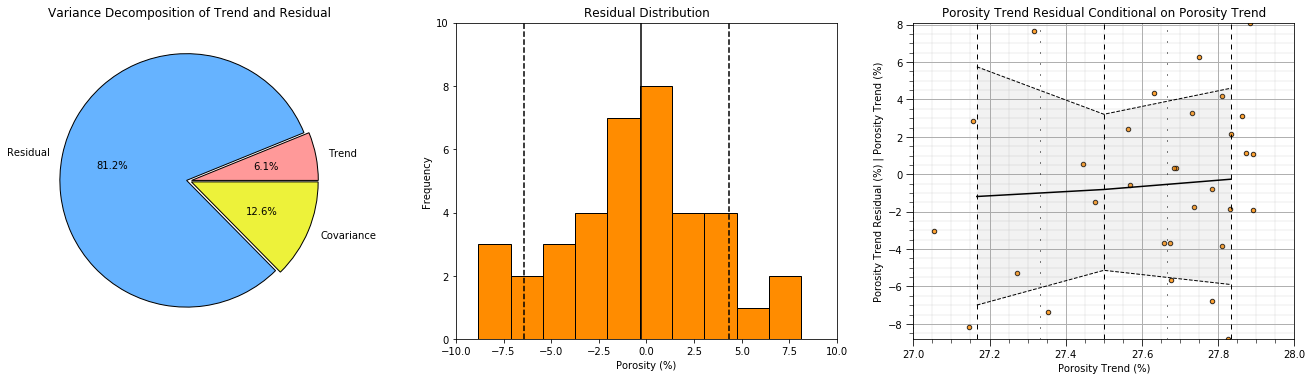

In [1046]:
df_centroids = GSLIB.sample(por_trend,xmin,ymin,xsiz,"Por_Trend",df_centroids_age,'X','Y')
df_centroids['Por_Res'] = df_centroids['Por'] - df_centroids['Por_Trend'] # calculate the residual and add to DataFrame
df_centroids.head()

var_trend = np.var(df_centroids['Por_Trend']); var_resid = np.var(df_centroids['Por_Res'])
cov_tr = np.cov(df_centroids['Por_Trend'],df_centroids['Por_Res'])[0,0]
var_total = var_trend + var_resid + 2* cov_tr

ptrend = var_trend / var_total; presid = var_resid / var_total; pcov = 2*cov_tr / var_total

plt.subplot(132)
plt.hist(df_centroids['Por_Res'],color='darkorange',edgecolor='black')
#histogram_bounds(df_centroids['Press'].values,np.ones(len(df_centroids)),'black')
p10,p50,p90 = weighted_percentile(df_centroids['Por_Res'].values,np.ones(len(df_centroids)),[0.1,0.5,0.9]) 
plt.plot([p10,p10],[0.0,10],color = 'black',linestyle='dashed')
plt.plot([p50,p50],[0.0,10],color = 'black')
plt.plot([p90,p90],[0.0,10],color = 'black',linestyle='dashed')
plt.title('Residual Distribution'); plt.xlabel('Porosity (%)'); plt.ylabel('Frequency')
plt.xlim([-10,10]); plt.ylim([0,10])

plt.subplot(133)
cond_prob_plot(df_centroids['Por_Trend'],27,28,'Porosity Trend','%',3,df_centroids['Por_Res'],
               min(df_centroids['Por_Res'].values),max(df_centroids['Por_Res'].values),'Porosity Trend Residual','%')

plt.subplot(131)                                       
plt.pie([ptrend, presid, pcov],labels = ['Trend','Residual', 'Covariance'],radius = 1, autopct='%1.1f%%', colors = ['#ff9999','#66b3ff','#edf23a'], explode = [.02,.02,0.02], wedgeprops = {"edgecolor":"k",'linewidth': 1}  )
plt.title('Variance Decomposition of Trend and Residual')



plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.3)
plt.show()

#### Extract Polygons and Hard Data

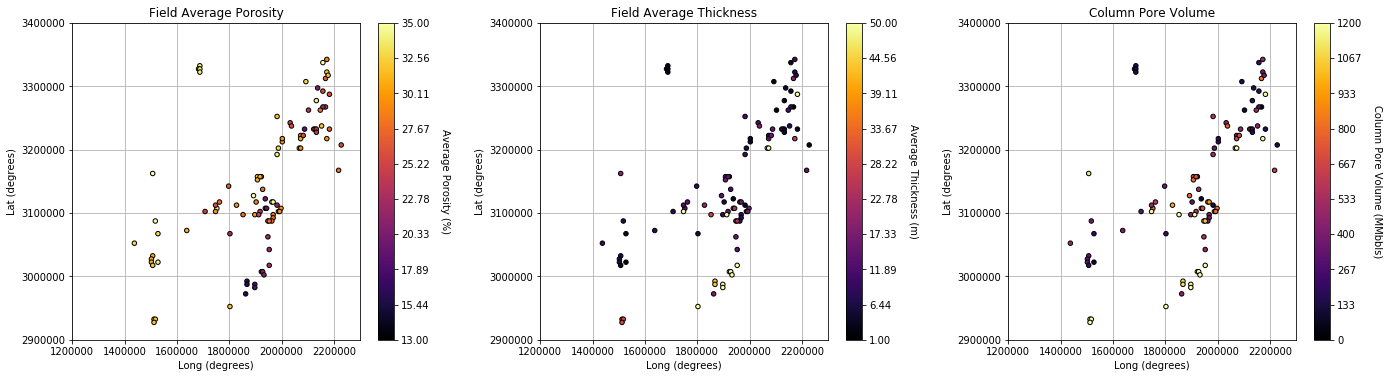

X          Y   Por  Thick            Name  ColumnPoreVolume
0  1752500.0  3107500.0  34.0  15.00         Serrano          801.9750
1  2157500.0  3337500.0  36.0   4.00      Ram-Powell          226.4400
2  2132500.0  3277500.0  34.0   3.62          Kepler          193.5433
3  1527500.0  3067500.0  33.0   4.00  Boomvang North          207.5700
4  1507500.0  3032500.0  31.0   7.00           Diana          341.2325

In [1047]:
ldatax = []; ldatay = []; ldatapor = []; ldatathick = []; ldataarea = []; ldataname = []
for i, poly in enumerate(poly_list):
    im = polygon_plotter(poly,por[i],pormin,pormax,plt.cm.inferno)
    dx,dy,dpor = polygon_extract_data(poly,por[i],xx,yy)
    dthick = np.full(len(dx),thick[i])
    dname = np.full(len(dx),name[i])
    if len(dx) > 0:
        ldatax.extend(dx.tolist()); ldatay.extend(dy.tolist()); ldatapor.extend(dpor.tolist())
        ldatathick.extend(dthick.tolist()); ldataname.extend(dname.tolist())
        
datax = np.array(ldatax); datay = np.array(ldatay); datapor = np.array(ldatapor)
datathick = np.array(ldatathick); dataarea = np.array(ldataarea); dataname = np.array(ldataname)
df_raster = pd.DataFrame({'X':datax,'Y':datay,'Por':datapor,'Thick':datathick,'Name':dataname})

df_raster['ColumnPoreVolume'] = xsiz*ysiz*df_raster['Thick']*df_raster['Por']/100*6.29/1000000

plt.subplot(131)
plt.scatter(df_raster['X'],df_raster['Y'],c=df_raster['Por'],vmin=pormin,vmax=pormax,cmap=cmap,edgecolor='black',s=20)
plt.title('Field Average Porosity'); plt.xlabel('Long (degrees)'); plt.ylabel('Lat (degrees)')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
plt.grid(True)
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(pormin, pormax, 10))
cbar.set_label('Average Porosity (%)', rotation=270, labelpad=20)

plt.subplot(132)
scat = plt.scatter(df_raster['X'],df_raster['Y'],c=df_raster['Thick'],vmin=thickmin,vmax=thickmax,cmap=cmap,edgecolor='black',s=20)
plt.title('Field Average Thickness'); plt.xlabel('Long (degrees)'); plt.ylabel('Lat (degrees)')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
plt.grid(True)
cbar = plt.colorbar(scat, orientation="vertical", ticks=np.linspace(thickmin, thickmax, 10))
cbar.set_label('Average Thickness (m)', rotation=270, labelpad=20)

plt.subplot(133)
scat = plt.scatter(df_raster['X'],df_raster['Y'],c=df_raster['ColumnPoreVolume'],vmin=volmin,vmax=volmax*0.2,cmap=cmap,edgecolor='black',s=20)
plt.title('Column Pore Volume'); plt.xlabel('Long (degrees)'); plt.ylabel('Lat (degrees)')
plt.xlim([xmin,xmax]); plt.ylim([ymin,ymax])
plt.grid(True)
cbar = plt.colorbar(scat, orientation="vertical", ticks=np.linspace(volmin, volmax*0.2, 10))
cbar.set_label('Column Pore Volume (MMbbls)', rotation=270, labelpad=20)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.3, hspace=0.3)
plt.show()

df_raster.head()

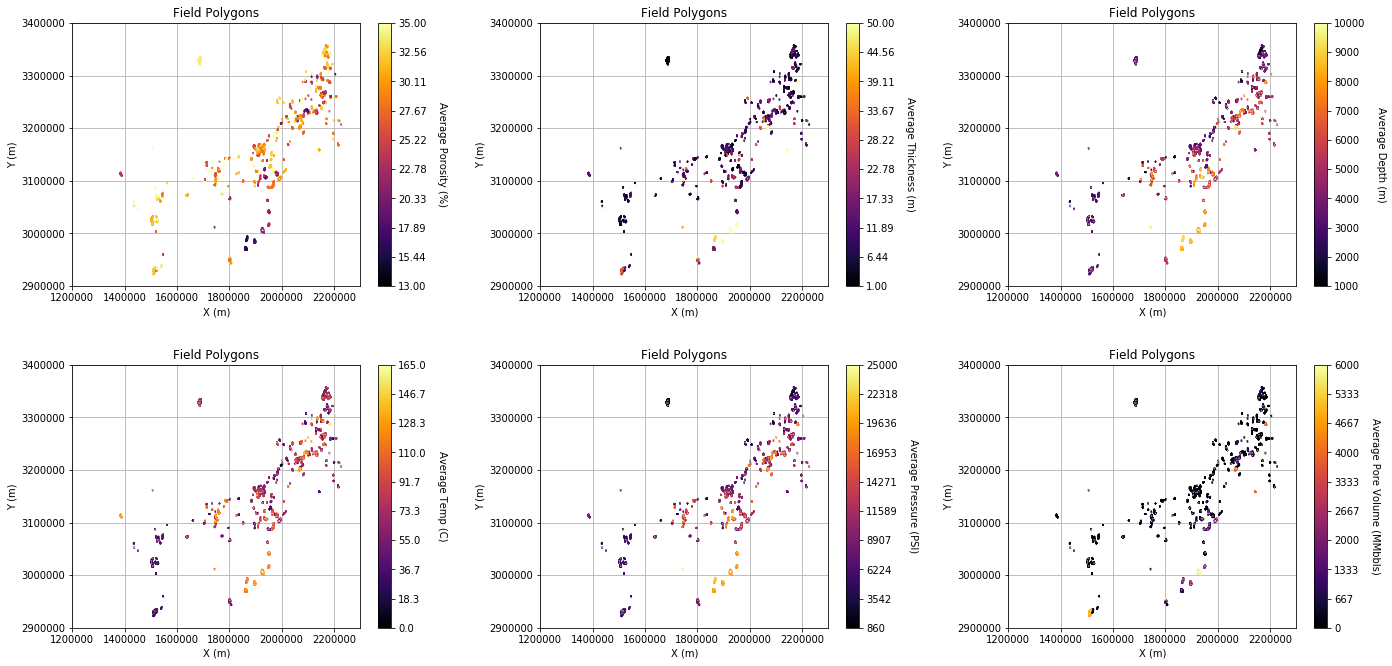

In [1048]:
plt.subplot(231)
polygon_plot_all(por,pormin,pormax,'Por','Porosity (%)',True)

plt.subplot(232)
polygon_plot_all(thick,thickmin,thickmax,'Thick','Thickness (m)',True)

plt.subplot(233)
polygon_plot_all(depth,depthmin,depthmax,'Depth','Depth (m)',True)

plt.subplot(234)
polygon_plot_all(temp,tempmin,tempmax,'Temp','Temp (C)',True)

plt.subplot(235)
polygon_plot_all(press,pressmin,pressmax,'Press','Pressure (PSI)',True)

plt.subplot(236)
polygon_plot_all(vol,volmin,volmax,'Volume','Pore Volume (MMbbls)',True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.3, hspace=0.3)
plt.show()

#### Declustering

There are 98 data with:
   mean of      28.040816326530614 
   min and max  16.0 and 36.0
   standard dev 5.0079902835917895 
Selected Cell Size: 288064.0
Naive mean = 28.040816326530614, Declustered mean = 29.722423583575964.


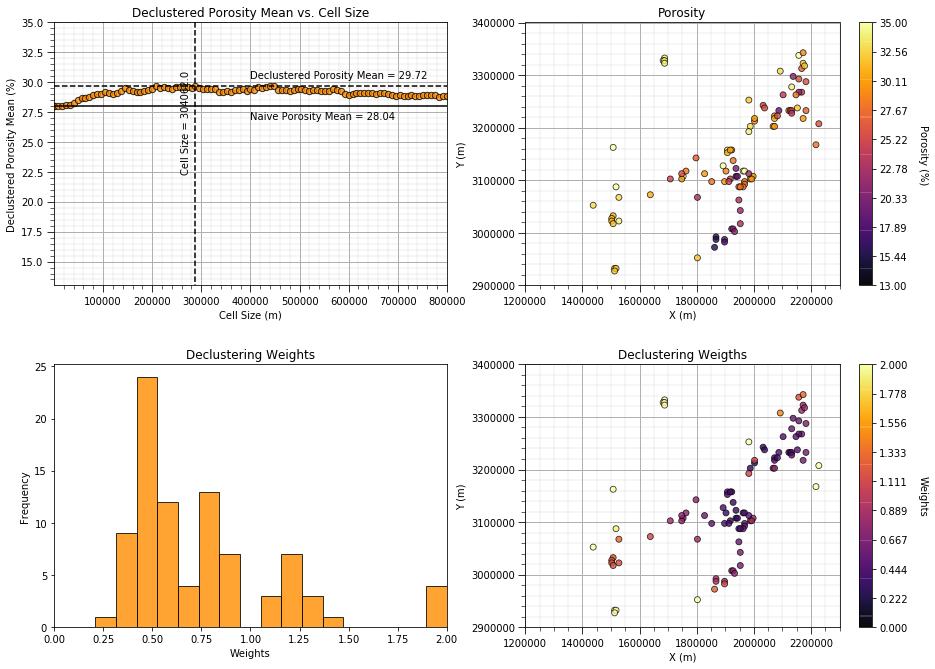

In [1068]:
#rcmin = 100.0; rcmax = 30000000; rncell = 100
rcmin = cmin; rcmax = cmax; rncell = ncell; riminmax = iminmax
riminmax = 0

rwts, rcell_sizes, rdmeans = geostats.declus(df_raster,'X','Y','Por',iminmax = riminmax, noff= 10, ncell=rncell,cmin=rcmin,cmax=rcmax)
df_raster['Wts'] = rwts                            # add weights to the sample data DataFrame
df_raster.head()                                  # preview to check the sample data DataFrame

if riminmax == 1:
    ricell_size = np.argmin(rdmeans)
else:
    ricell_size = np.argmax(rdmeans)
rcell_size = rcell_sizes[ricell_size]

print('Selected Cell Size: ' + str(rcell_size))

por_raster_mean = np.average(df_raster['Por'].values); por_raster_var = np.var(df_raster['Por'].values)
por_raster_dmean,por_raster_dstd = weighted_avg_and_std(df_raster['Por'].values,df_raster['Wts'].values)
por_raster_dvar = por_raster_dstd*por_raster_dstd

thick_raster_mean = np.average(df_raster['Thick'].values); thick_raster_var = np.var(df_raster['Thick'].values)
thick_raster_dmean,thick_raster_dstd = weighted_avg_and_std(df_raster['Por'].values,df_raster['Wts'].values)
thick_raster_dvar = thick_raster_dstd*thick_raster_dstd

print('Naive mean = ' + str(por_raster_mean) + ', Declustered mean = ' + str(por_raster_dmean) + '.')

plt.subplot(221)
plt.scatter(rcell_sizes,rdmeans, s=40, alpha = 0.8, edgecolors = "black", facecolors = 'darkorange')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (%)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,rcmax],[por_raster_mean,por_raster_mean],color = 'black')
plt.plot([rcell_size,rcell_size],[0,999],color = 'black',linestyle='dashed')
plt.plot([0,rcmax],[por_raster_dmean,por_raster_dmean],color = 'black',linestyle='dashed')
plt.text(rcmax*0.5,por_raster_mean*0.96, r'Naive Porosity Mean = ' + str(np.round(por_raster_mean,2)))
plt.text(rcmax*0.5,por_raster_dmean*1.02, r'Declustered Porosity Mean = ' + str(np.round(por_raster_dmean,2)))
# plt.text(230., 0.154, r'Minimizing')
plt.text(rcell_size*.90, por_raster_mean*0.8, r'Cell Size = ' + str(np.round(cell_size,2)),rotation=90)
plt.ylim(pormin,pormax); plt.xlim(cmin,cmax); add_grid()
#plt.xscale('log');

plt.subplot(222)
GSLIB.locmap_st(df_raster,"X","Y","Por",xmin,xmax,ymin,ymax,pormin,pormax,'Porosity','X (m)','Y (m)',"Porosity (%)",cmap)
add_grid()

plt.subplot(223)
plt.hist(df_raster['Wts'],bins=np.linspace(0.0,2.0,20),color='darkorange',edgecolor='black',alpha=0.8)
plt.xlim([0.0,2.0]); plt.xlabel('Weights'); plt.ylabel('Frequency'); plt.title('Declustering Weights')

plt.subplot(224)
GSLIB.locmap_st(df_raster,"X","Y","Wts",xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weigths','X (m)','Y (m)',"Weights",cmap)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.3)
plt.show()


# por_mean = np.average(df_raster['Por'].values)
# por_dmean = np.average(df_raster['Por'].values,weights=df_raster['Wts'].values)
# por_var = np.var(df_raster['Por'].values)
# thick_mean = np.average(df_raster['Thick'].values)
# thick_dmean = np.average(df_raster['Thick'].values,weights=df_raster['Wts'].values)
# thick_var = np.var(df_raster['Thick'].values)

# print('Naive mean = ' + str(por_mean) + ', Declustered mean = ' + str(por_dmean) + '.')

# plt.subplot(111)
# plt.scatter(cell_sizes,dmeans, s=40, alpha = 0.8, edgecolors = "black", facecolors = 'darkorange')
# plt.xlabel('Cell Size (m)')
# plt.ylabel('Declustered Porosity Mean (fraction)')
# plt.title('Declustered Porosity Mean vs. Cell Size')
# # plt.plot([0,2000],[por_mean,por_mean],color = 'black')
# # plt.plot([200,200],[pormin,pormax],color = 'black',linestyle='dashed')
# # plt.text(300., 0.136, r'Naive Porosity Mean')
# # plt.text(500., 0.118, r'Declustered Porosity Mean')
# # plt.text(230., 0.154, r'Minimizing')
# # plt.text(230., 0.150, r'Cell Size')
# plt.ylim(pormin,pormax)
# # plt.xlim(0,0.10)
# plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
# plt.show()

#### Univariate Distributions

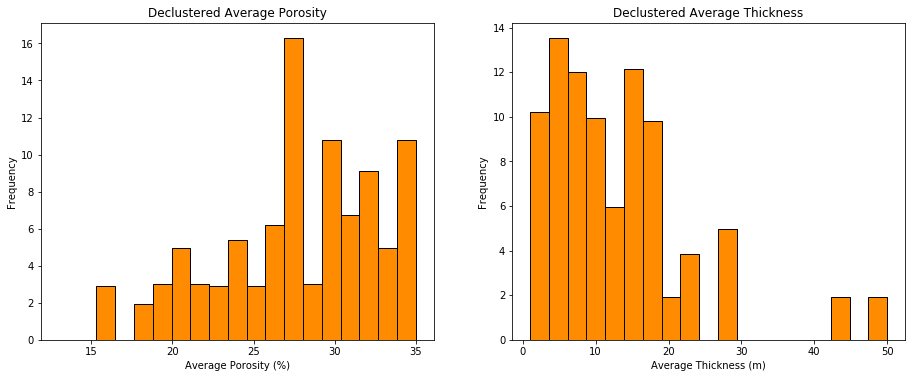

In [860]:
nbins = 20
plt.subplot(121)
plt.hist(df_raster['Por'],weights = df_raster['Wts'],bins=np.linspace(pormin,pormax,nbins),color='darkorange',edgecolor='black')
plt.xlabel('Average Porosity (%)'); plt.ylabel('Frequency'); plt.title('Declustered Average Porosity')

plt.subplot(122)
plt.hist(df_raster['Thick'],weights = df_raster['Wts'],bins=np.linspace(thickmin,thickmax,nbins),color='darkorange',edgecolor='black')
plt.xlabel('Average Thickness (m)'); plt.ylabel('Frequency'); plt.title('Declustered Average Thickness')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Bivariate 

From the enhanced correlation analysis, we see that average porosity and average thickness are not correlated.

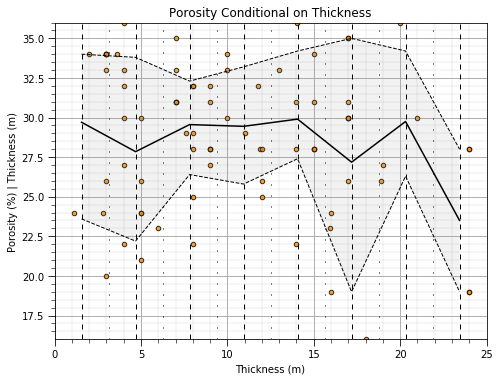

In [1071]:
plt.subplot(111)
cond_prob_plot(df_raster['Thick'],0,25,'Thickness','m',8,df_raster['Por'],
               min(df_raster['Por'].values),max(df_raster['Por'].values),'Porosity','%')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Variography

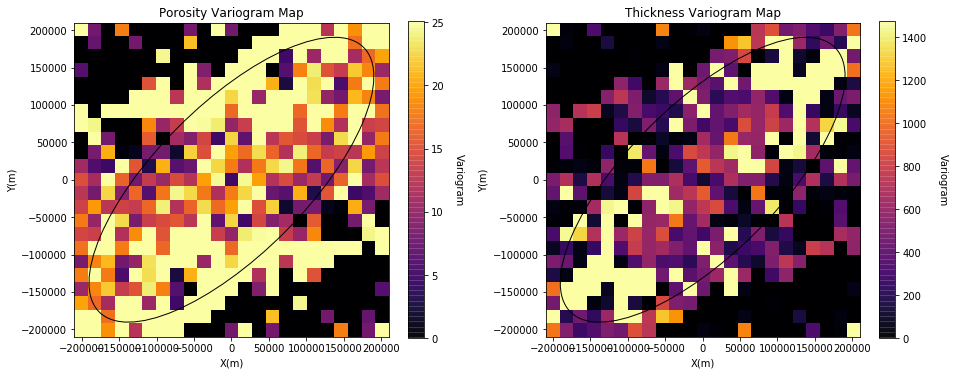

In [1072]:
dlag = 20000; nlag = 11
por_vmap, por_npmap = geostats.varmapv(df_raster,'X','Y','Por',tmin=-999,tmax=999,nxlag=nlag,nylag=nlag,dxlag=dlag,dylag=dlag,minnp=1,isill=1)
thick_vmap, thick_npmap = geostats.varmapv(df_raster,'X','Y','Thick',tmin=-999,tmax=999,nxlag=nlag,nylag=nlag,dxlag=dlag,dylag=dlag,minnp=1,isill=1)

plt.subplot(121)
GSLIB.pixelplt_st(por_vmap,-210000,210000,-210000,210000,dlag,0,por_var,'Porosity Variogram Map','X(m)','Y(m)','Variogram',cmap)
plt.gca().add_patch(Ellipse((0,0),width=500000,height=200000,angle=45,facecolor='none',edgecolor='black',label='Low')) 

plt.subplot(122)
GSLIB.pixelplt_st(thick_vmap,-210000,210000,-210000,210000,dlag,0,thick_var,'Thickness Variogram Map','X(m)','Y(m)','Variogram',cmap)
plt.gca().add_patch(Ellipse((0,0),width=500000,height=200000,angle=45,facecolor='none',edgecolor='black',label='Low')) 

por_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=240000,hmin1=70000) # porosity variogram
thick_vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=240000,hmin1=70000) # thickness variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=2., top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Spatial Estimation

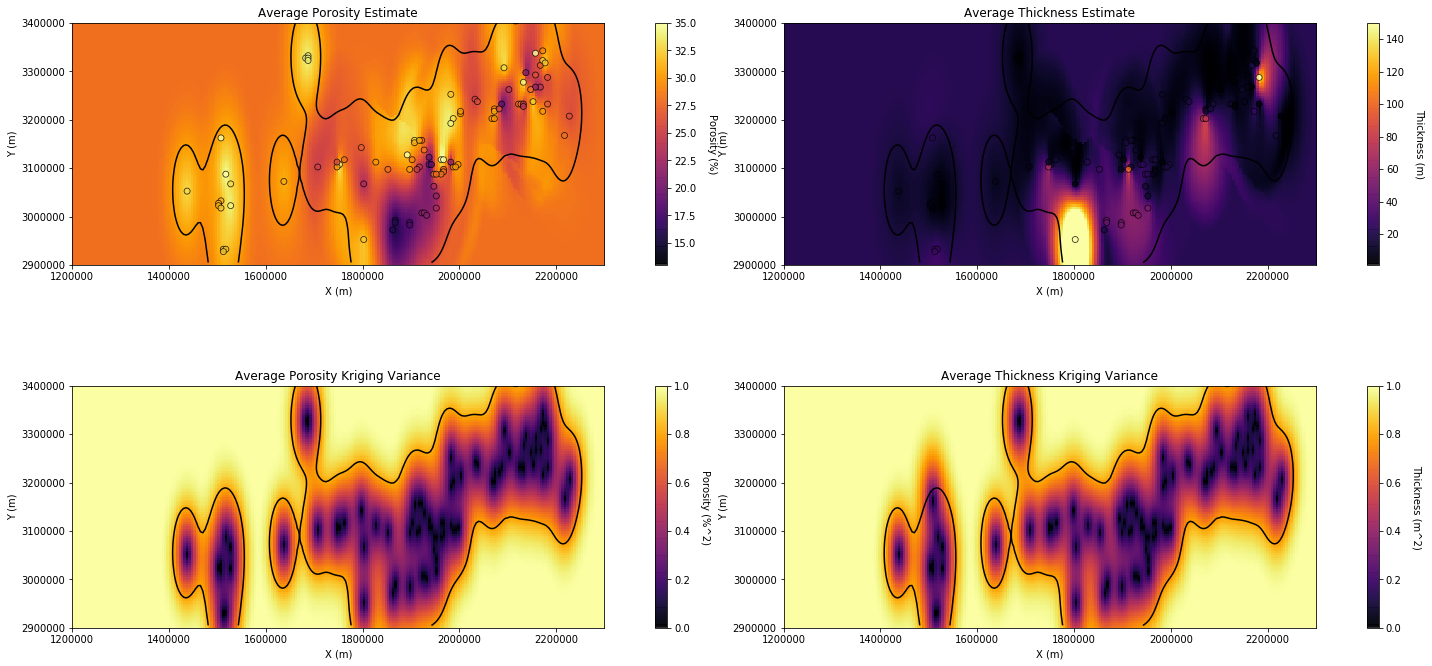

In [1073]:
skmean_por = 32;                           # simple kriging mean (used if simple kriging is selected below)
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
radius = 1000000                           # search radius for neighbouring data
nxdis = 1; nydis = 1                       # number of grid discretizations for block kriging (not tested)
ndmin = 0; ndmax = 50                      # minimum and maximum data for an estimate
tmin = pormin; tmax = pormax               # minimum property value

calculate = False

if calculate == True:
    por_kmap, por_vmap = geostats.kb2d(df_raster,'X','Y','Por',pormin,pormax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,radius,ktype,por_dmean,por_vario)
    thick_kmap, thick_vmap = geostats.kb2d(df_raster,'X','Y','Thick',-999,999,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
             ndmin,ndmax,radius,ktype,thick_dmean,por_vario)
    np.savetxt("por_kmap.csv", por_kmap, delimiter=","); np.savetxt("por_vmap.csv", por_vmap, delimiter=",");
    np.savetxt("thick_kmap.csv", thick_kmap, delimiter=","); np.savetxt("thick_vmap.csv", thick_vmap, delimiter=",");
else:
    por_kmap = np.loadtxt("por_kmap.csv", delimiter=","); thick_kmap = np.loadtxt("thick_kmap.csv", delimiter=",")  
    por_vmap = np.loadtxt("por_vmap.csv", delimiter=","); thick_vmap = np.loadtxt("thick_vmap.csv", delimiter=",")  
    
plt.subplot(221)
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df_raster,'X','Y','Por','Average Porosity Estimate','X (m)','Y (m)','Porosity (%)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(223)
GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Average Porosity Kriging Variance','X (m)','Y (m)','Porosity (%^2)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(222)
GSLIB.locpix_st(thick_kmap,xmin,xmax,ymin,ymax,xsiz,thickmin,150,df_raster,'X','Y','Thick','Average Thickness Estimate','X (m)','Y (m)','Thickness (m)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(224)
GSLIB.pixelplt_st(thick_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Average Thickness Kriging Variance','X (m)','Y (m)','Thickness (m^2)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=-.30, hspace=0.5)
plt.show()

#### Expected Column Por Volume

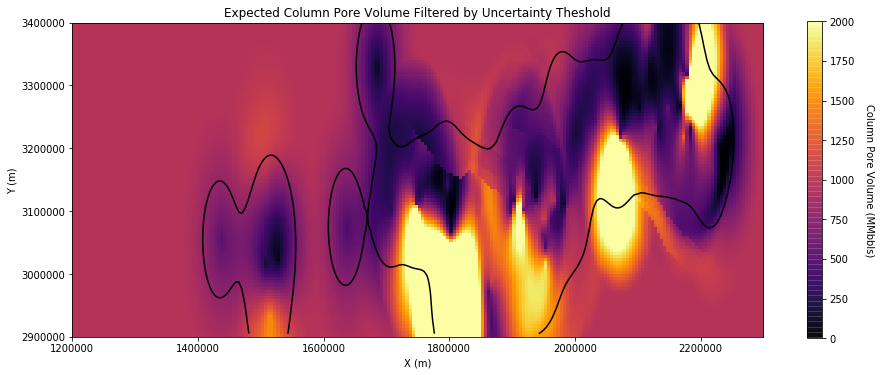

In [1074]:
plt.subplot(111)
vol_map = por_kmap/100 * thick_kmap * xsiz * ysiz * 6.29 / 1000000
#vol_map = np.where((por_vmap > 0.9), -9999, vol_map)
GSLIB.pixelplt_st(vol_map,xmin,xmax,ymin,ymax,xsiz,0,2000,'Expected Column Pore Volume Filtered by Uncertainty Theshold','X (m)','Y (m)','Column Pore Volume (MMbbls)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.3)
plt.show()

#### Local Uncertainty

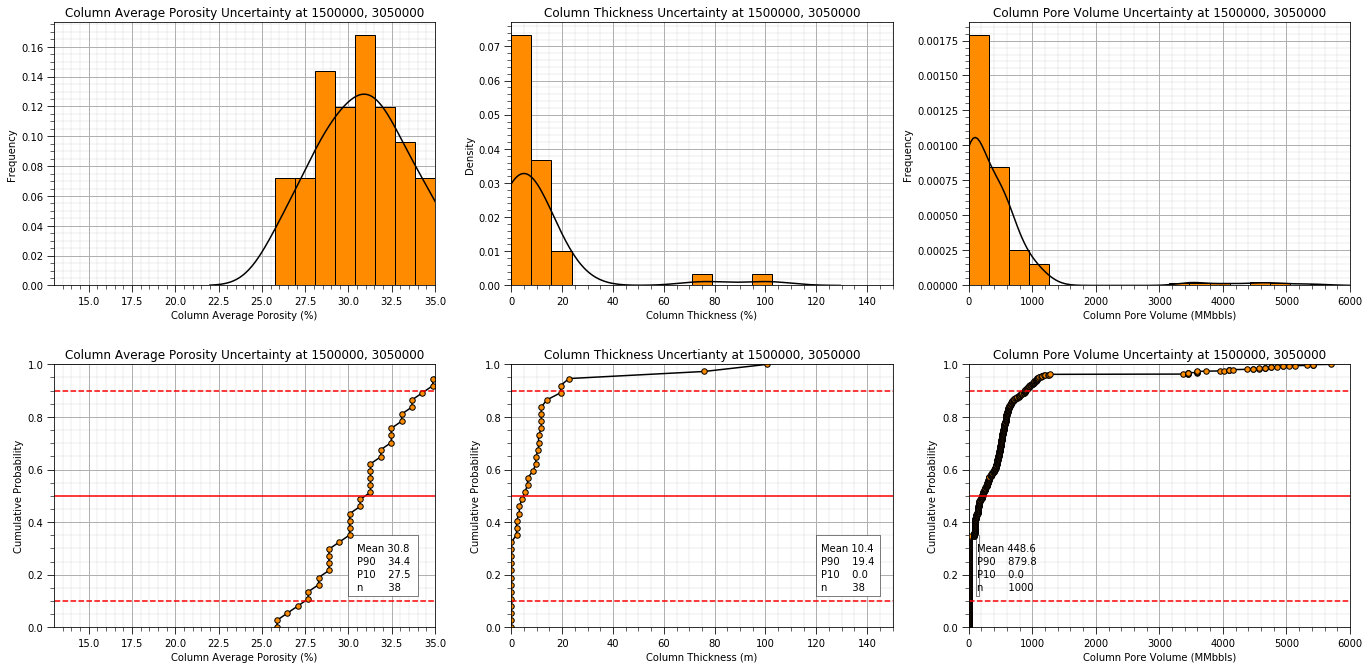

In [1075]:
xloc = 1500000; yloc = 3050000; L = 1000
ix = geostats.getindex(nx,xmn,xsiz,xloc); iy = ny-geostats.getindex(ny,ymn,ysiz,yloc)-1

lpor_mean = por_kmap[iy,ix]; lthick_mean = thick_kmap[iy,ix]
lpor_var = por_vmap[iy,ix]*por_var; lthick_var = thick_vmap[iy,ix]*thick_var
lpor_std = math.sqrt(lpor_var); lthick_std = math.sqrt(lthick_var)

lpor = GSLIB.affine(df_centroids_age['Por'].values,lpor_mean,lpor_std)
lthick = GSLIB.affine(df_centroids_age['Thick'].values,lthick_mean,lthick_std)

lpor = np.where((lpor < 0.0), 0, lpor)
lthick = np.where((lthick < 0.0), 0, lthick)

rpor = np.random.choice(lpor,size=L)
rthick = np.random.choice(lthick,size=L)
rvol = rpor/100*rthick*xsiz*ysiz*6.29/1000000

nbins = 20

plt.subplot(231)
plt.hist(lpor,bins=np.linspace(pormin,pormax,nbins),color='darkorange',edgecolor='black',density = True)
plt.xlim([pormin,pormax]); 
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Column Average Porosity (%)'); plt.ylabel('Frequency'); plt.title('Column Average Porosity Uncertainty at ' + str(xloc) + ', ' + str(yloc))
sns.kdeplot(x=lpor,color = 'black',alpha = 1.0,levels = 10)

plt.subplot(232)
plt.hist(lthick,bins=np.linspace(0,150,nbins),color='darkorange',edgecolor='black',density = True)
plt.xlim([0,150]); 
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Column Thickness (%)'); plt.ylabel('Density'); plt.title('Column Thickness Uncertainty at ' + str(xloc) + ', ' + str(yloc))
sns.kdeplot(x=lthick,color = 'black',alpha = 1.0,levels = 10)

plt.subplot(233)
plt.hist(rvol,bins=np.linspace(volmin,volmax,nbins),color='darkorange',edgecolor='black',density = True)
plt.xlim([volmin,volmax]); 
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.xlabel('Column Pore Volume (MMbbls)'); plt.ylabel('Frequency'); plt.title('Column Pore Volume Uncertainty at ' + str(xloc) + ', ' + str(yloc))
sns.kdeplot(x=rvol,color = 'black',alpha = 1.0,levels = 10)

plt.subplot(234)
plt.plot(np.sort(lpor),np.linspace(0.0,1.0,len(lpor)),color='black',alpha=1.0,zorder=1)
plt.scatter(np.sort(lpor),np.linspace(0.0,1.0,len(lpor)),s=30,color='darkorange',edgecolor='black',zorder=2)
plt.ylim([0,1]); plt.xlim([pormin,pormax]); plt.xlabel('Column Average Porosity (%)'); plt.ylabel('Cumulative Probability'); plt.title('Column Average Porosity Uncertainty at ' + str(xloc) + ', ' + str(yloc))
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([volmin,volmax],[0.1,0.1],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.9,0.9],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.5,0.5],color='red')

plt.gca().add_patch(Rectangle((30.0,0.12),4.0,0.23,facecolor='white',edgecolor='black',linewidth=0.5)); plt.text(30.5,0.29,'Mean ' + str(round(np.average(lpor),1))); plt.text(30.5,0.24,'P90    ' + str(round(np.percentile(lpor,90),1))); plt.text(30.5,0.19,'P10    ' + str(round(np.percentile(lpor,10),1))); plt.text(30.5,0.14,'n        ' + str(len(lpor)))

plt.subplot(235)
plt.plot(np.sort(lthick),np.linspace(0.0,1.0,len(lthick)),color='black',alpha=1.0,zorder=1)
plt.scatter(np.sort(lthick),np.linspace(0.0,1.0,len(lthick)),s=30,color='darkorange',edgecolor='black',zorder=2)
plt.ylim([0,1]); plt.xlim([0,150]); plt.xlabel('Column Thickness (m)'); plt.ylabel('Cumulative Probability'); plt.title('Column Thickness Uncertianty at ' + str(xloc) + ', ' + str(yloc))
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([volmin,volmax],[0.1,0.1],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.9,0.9],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.5,0.5],color='red')

plt.gca().add_patch(Rectangle((120.0,0.12),25.0,0.23,facecolor='white',edgecolor='black',linewidth=0.5)); plt.text(122,0.29,'Mean ' + str(round(np.average(lthick),1))); plt.text(122,0.24,'P90    ' + str(round(np.percentile(lthick,90),1))); plt.text(122,0.19,'P10    ' + str(round(np.percentile(lthick,10),1))); plt.text(122,0.14,'n        ' + str(len(lthick)))

plt.subplot(236)
plt.plot(np.sort(rvol),np.linspace(0.0,1.0,len(rvol)),color='black',alpha=1.0,zorder=1)
plt.scatter(np.sort(rvol),np.linspace(0.0,1.0,len(rvol)),s=30,color='darkorange',edgecolor='black',zorder=2)
plt.ylim([0,1]); plt.xlim([volmin,volmax]); plt.xlabel('Column Pore Volume (MMbbls)'); plt.ylabel('Cumulative Probability'); plt.title('Column Pore Volume Uncertainty at ' + str(xloc) + ', ' + str(yloc))
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([volmin,volmax],[0.1,0.1],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.9,0.9],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.5,0.5],color='red')

plt.gca().add_patch(Rectangle((120.0,0.12),35.0,0.23,facecolor='white',edgecolor='black',linewidth=0.5)); plt.text(122,0.29,'Mean ' + str(round(np.average(rvol),1))); plt.text(122,0.24,'P90    ' + str(round(np.percentile(rvol,90),1))); plt.text(122,0.19,'P10    ' + str(round(np.percentile(rvol,10),1))); plt.text(122,0.14,'n        ' + str(len(rvol)))

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=2.1, wspace=0.2, hspace=0.3)
plt.show()


#### Build a Smoothed Reference Distribution

This is quite simple will replace with more sophisticated methods latter

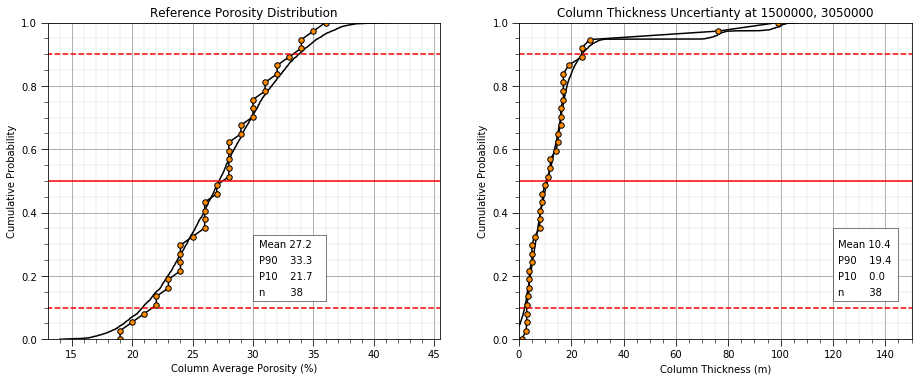

In [1102]:
por_ref = []; thick_ref = []; L = 100; por_stdev = 2.0; thick_stdev = 3.0
for i in range(0,len(df_centroids_age)):
    for l in range(0,L):
        por_ref.append(df_centroids_age['Por'].values[i] + np.random.normal(loc=0,scale=por_stdev))
        thick_ref.append(df_centroids_age['Thick'].values[i] + np.random.normal(loc=0,scale=thick_stdev))

plt.subplot(121)
plt.plot(np.sort(df_centroids_age['Por']),np.linspace(0.0,1.0,len(df_centroids_age)),color='black',alpha=1.0,zorder=1)
plt.plot(np.sort(por_ref),np.linspace(0.0,1.0,len(por_ref)),color='black',alpha=1.0,zorder=1)
plt.scatter(np.sort(df_centroids_age['Por'].values),np.linspace(0.0,1.0,len(df_centroids_age)),s=30,color='darkorange',edgecolor='black',zorder=2)
plt.ylim([0,1]); plt.xlim([pormin,pormax*1.3]); plt.xlabel('Column Average Porosity (%)'); plt.ylabel('Cumulative Probability'); plt.title('Reference Porosity Distribution')
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([volmin,volmax],[0.1,0.1],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.9,0.9],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.5,0.5],color='red')

plt.gca().add_patch(Rectangle((30.0,0.12),6.0,0.21,facecolor='white',edgecolor='black',linewidth=0.5)); plt.text(30.5,0.29,'Mean ' + str(round(np.average(df_centroids_age['Por']),1))); plt.text(30.5,0.24,'P90    ' + str(round(np.percentile(df_centroids_age['Por'],90),1))); plt.text(30.5,0.19,'P10    ' + str(round(np.percentile(df_centroids_age['Por'],10),1))); plt.text(30.5,0.14,'n        ' + str(len(df_centroids_age['Por'])))

plt.subplot(122)
plt.plot(np.sort(df_centroids_age['Thick']),np.linspace(0.0,1.0,len(df_centroids_age)),color='black',alpha=1.0,zorder=1)
plt.plot(np.sort(thick_ref),np.linspace(0.0,1.0,len(por_ref)),color='black',alpha=1.0,zorder=1)
plt.scatter(np.sort(df_centroids_age['Thick'].values),np.linspace(0.0,1.0,len(df_centroids_age)),s=30,color='darkorange',edgecolor='black',zorder=2)
plt.ylim([0,1]); plt.xlim([0,150]); plt.xlabel('Column Thickness (m)'); plt.ylabel('Cumulative Probability'); plt.title('Column Thickness Uncertianty at ' + str(xloc) + ', ' + str(yloc))
plt.grid(True, which='major',linewidth = 1.0); plt.grid(True, which='minor',linewidth = 0.2) # add y grids
plt.tick_params(which='major',length=7); plt.tick_params(which='minor', length=4)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
plt.plot([volmin,volmax],[0.1,0.1],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.9,0.9],color='red',linestyle='--'); plt.plot([volmin,volmax],[0.5,0.5],color='red')

plt.gca().add_patch(Rectangle((120.0,0.12),25.0,0.23,facecolor='white',edgecolor='black',linewidth=0.5)); plt.text(122,0.29,'Mean ' + str(round(np.average(lthick),1))); plt.text(122,0.24,'P90    ' + str(round(np.percentile(lthick,90),1))); plt.text(122,0.19,'P10    ' + str(round(np.percentile(lthick,10),1))); plt.text(122,0.14,'n        ' + str(len(lthick)))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.3)
plt.show()

#### Uncertainty Maps

10
50
90


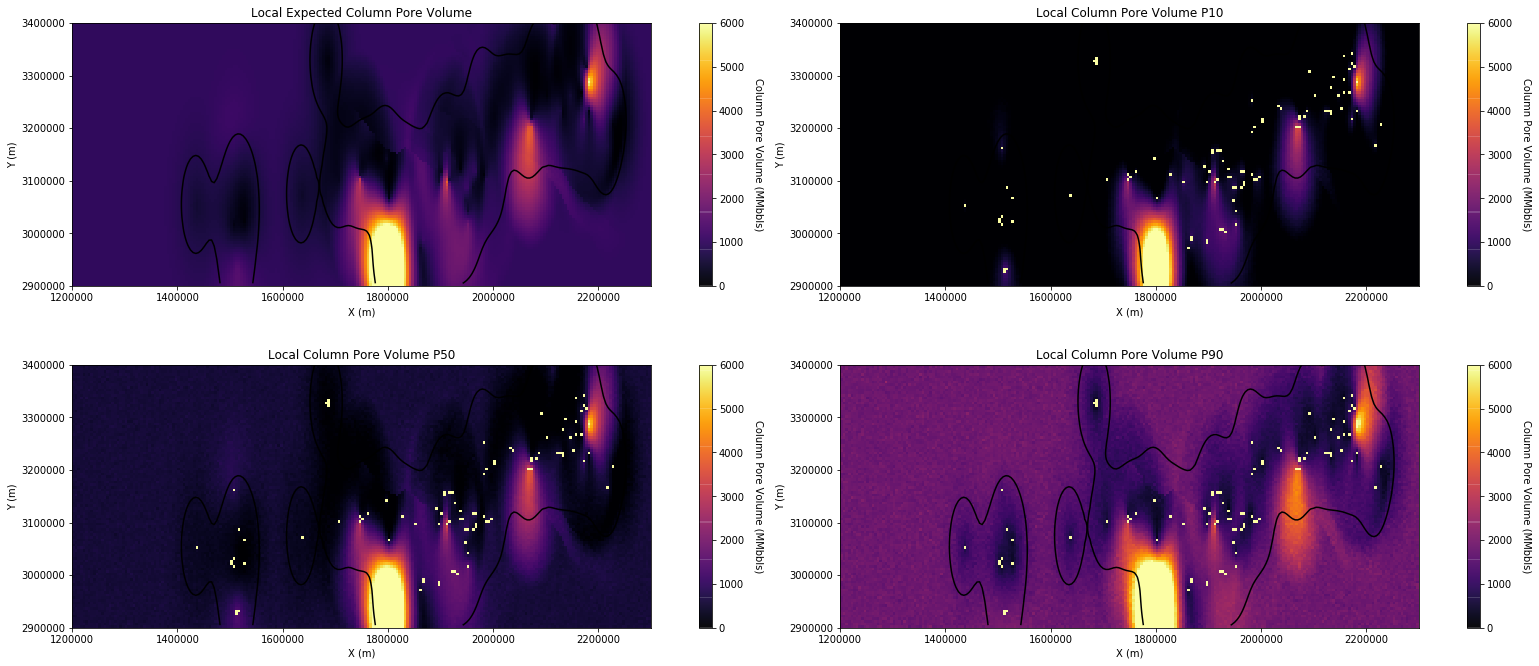

In [1104]:
localP10 = pmap(percentile=10)
# localP50 = pmap(percentile=50)
# localP90 = pmap(percentile=90)

plt.subplot(221)
GSLIB.pixelplt_st(vol_map,xmin,xmax,ymin,ymax,xsiz,0,6000,'Local Expected Column Pore Volume','X (m)','Y (m)','Column Pore Volume (MMbbls)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(222)
GSLIB.pixelplt_st(localP10,xmin,xmax,ymin,ymax,xsiz,0,6000,'Local Column Pore Volume P10','X (m)','Y (m)','Column Pore Volume (MMbbls)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(223)
GSLIB.pixelplt_st(localP50,xmin,xmax,ymin,ymax,xsiz,0,6000,'Local Column Pore Volume P50','X (m)','Y (m)','Column Pore Volume (MMbbls)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(224)
GSLIB.pixelplt_st(localP90,xmin,xmax,ymin,ymax,xsiz,0,6000,'Local Column Pore Volume P90','X (m)','Y (m)','Column Pore Volume (MMbbls)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=-0.2, hspace=0.3)
plt.show()

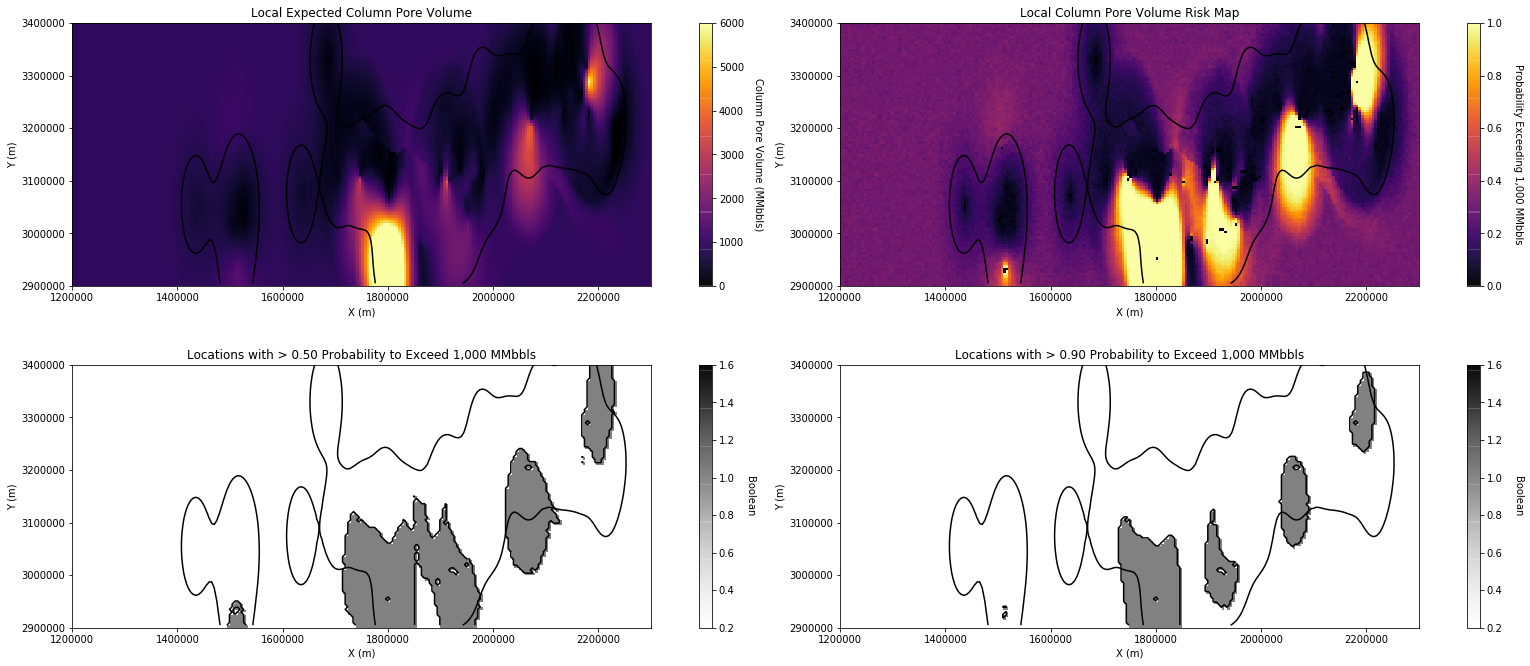

In [1135]:
localrisk,localsamples = rmap(threshold=1000)
# localP50 = pmap(percentile=50)
# localP90 = pmap(percentile=90)

plt.subplot(221)
GSLIB.pixelplt_st(vol_map,xmin,xmax,ymin,ymax,xsiz,0,6000,'Local Expected Column Pore Volume','X (m)','Y (m)','Column Pore Volume (MMbbls)',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(222)
GSLIB.pixelplt_st(localrisk,xmin,xmax,ymin,ymax,xsiz,0,1.0,'Local Column Pore Volume Risk Map','X (m)','Y (m)','Probability Exceeding 1,000 MMbbls',cmap)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(223)
GSLIB.pixelplt_st(localrisk>.50,xmin,xmax,ymin,ymax,xsiz,0.2,1.6,'Locations with > 0.50 Probability to Exceed 1,000 MMbbls','X (m)','Y (m)','Boolean',cmap = plt.cm.Greys)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])
add_contour_st(localrisk>.50,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplot(224)
GSLIB.pixelplt_st(localrisk>.90,xmin,xmax,ymin,ymax,xsiz,0.2,1.6,'Locations with > 0.90 Probability to Exceed 1,000 MMbbls','X (m)','Y (m)','Boolean',cmap = plt.cm.Greys)
add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])
add_contour_st(localrisk>.90,xmin,xmax,ymin,ymax,xsiz,[0.8])

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=-0.2, hspace=0.3)
plt.show()

In [1216]:
prob = widgets.FloatSlider(min=0.0, max = 1.0, value = .4, step = 0.05, description = 'Probability',orientation='horizontal',layout=Layout(width='470px', height='30px'),continuous_update=False)
prob.style.handle_color = 'darkorange'
thresh = widgets.FloatSlider(min=100, max = 10000.0, value = 500.0, step = 100.0, description = 'Min Volume (MMbbls)',orientation='horizontal',layout=Layout(width='470px', height='30px'),continuous_update=False)
thresh.style.handle_color = 'darkorange'

l = widgets.Text(value='                                      Boostrap Demonstration, Michael Pyrcz, Associate Professor, The University of Texas at Austin',layout=Layout(width='950px', height='30px'))
ui = widgets.HBox([prob,thresh],)                      # basic widget formatting           
ui2 = widgets.VBox([l,ui],)

def f_make(prob,thresh):                           # function to take parameters, make sample and plot
    
    lrmap = np.zeros((ny,nx))
    for iy in range(0,ny):
        for ix in range(0,nx):
            if por_vmap[iy,ix] < 0.8:
                lrmap[iy,ix] = (localsamples[iy,ix,:] >= thresh).sum()/1000
    
    plt.subplot(111)
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax, xsiz), np.arange(ymax, ymin, -1 * ysiz)
    )
    im = plt.imshow(por_vmap,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = 0.0, vmax = 1.0,cmap = cmap)
    
    plt.imshow(lrmap>prob,alpha=0.8,interpolation = None,extent = [xmin,xmax,ymin,ymax], vmin = 0.2, vmax = 1.6,cmap = plt.cm.Greys)
    plt.title('Locations with > ' + str(prob) + ' Probability to Exceed ' + str(threshold) + ' MMbbls')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')


    plt.contour(xx,yy,por_vmap,vmin=volmin,vmax=volmax,levels=[0.8],colors='black',linestyles='dashed',linewidths=2)

    #add_contour_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,[0.8])
    add_contour_st(lrmap>prob,xmin,xmax,ymin,ymax,xsiz,[0.8])
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=2.1, wspace=-0.2, hspace=0.3)
    plt.show()
    
# connect the function to make the samples and plot to the widgets    
interactive_plot = widgets.interactive_output(f_make, {'prob': prob,'thresh': thresh})
interactive_plot.clear_output(wait = True)                # reduce flickering by delaying plot updating# connect the function to make the samples and plot to the widgets    

In [1217]:
display(ui2, interactive_plot)                            # display the interactive plot

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 432x288 with 1 Axes>', 'i…

In [ ]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# raterize
nx = 100; ny = 100
xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
xmn = xmin + xsiz*0.5; ymn = ymin + ysiz*0.5

xmn = 96



nx, ny = 10, 10
poly_verts = [(1,1), (5,1), (5,9),(3,2),(1,1)]

# Create vertex coordinates for each grid cell...
# (<0,0> is at the top left of the grid in this system)
xx, yy = np.meshgrid(
    np.arange(xmin, xmax, step), np.arange(ymax, ymin, -1 * step)
x, y = x.flatten(), y.flatten()

points = np.vstack((x,y)).T

for 
grid = points_inside_poly(points, poly_verts)
grid = grid.reshape((ny,nx))

print grid


In [ ]:
polygons = df['WKT'].values
polygons[2]

In [ ]:
import re
val_list = [float(s) for s in re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",polygons[0])]
x = val_list[::2]; y = val_list[1::2]
plt.plot(x,y)

In [ ]:
for i, spoly in enumerate(polygons):
    poly = polygon_extractor(spoly)
    polygon_plotter(poly)
    
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
polygons[1]

In [ ]:
ndarray_list = []
str_list = []
str_list = polygons[2].split("))")
for i, poly in enumerate(str_list):
    val_list = [float(s) for s in re.findall("[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?",poly)]
    lat = val_list[::2]; long = val_list[1::2]    
    ndarray_list.append(np.column_stack((lat, long)))    
type(ndarray_list[0])

for i, poly in enumerate(ndarray_list):
    plt.plot(ndarray_list[i][:,0],ndarray_list[i][:,1])

In [ ]:
poly = polygon_extractor(polygons[1])
len(poly)

In [ ]:
polygons[2]